In [ ]:
# INSTALACIÓN

!pip install -q transformers torch datasets accelerate peft bitsandbytes sentencepiece protobuf
!pip install -q bert-score textstat nltk scikit-learn pandas numpy matplotlib seaborn
!pip install -q openai anthropic google-generativeai
!pip install -q wandb

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
print("Instalación completada")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.0/355.0 kB 18.1 MB/s eta 0:00:00
Instalación completada


In [ ]:
# IMPORTACIONES
import warnings
warnings.filterwarnings('ignore')

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from transformers import (
    AutoTokenizer, AutoModelForCausalLM, AutoModel,
    AutoModelForSeq2SeqLM, TrainingArguments,
    Seq2SeqTrainingArguments, BitsAndBytesConfig, pipeline
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from datasets import Dataset

from bert_score import score as bert_score
import textstat

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Device: cuda
GPU: NVIDIA A100-SXM4-80GB


In [ ]:
class EvaluationMetrics:
    def __init__(self):
        self.nli = pipeline(
            "text-classification",
            model="microsoft/deberta-v3-small",
            device=0 if torch.cuda.is_available() else -1
        )

    def calculate_relevance(self, generated, reference):
        P, R, F1 = bert_score([generated], [reference], lang="en", verbose=False)
        return {"precision": P.item(), "recall": R.item(), "f1": F1.item()}

    def calculate_factual(self, generated, source):
        result = self.nli(f"{source} [SEP] {generated}")
        return {"score": result[0]['score']}

    def calculate_readability(self, text):

        return {
            "flesch_reading_ease": textstat.flesch_reading_ease(text),
            "flesch_kincaid_grade": textstat.flesch_kincaid_grade(text),
            "coleman_liau_index": textstat.coleman_liau_index(text),
            "gunning_fog": textstat.gunning_fog(text),
            "smog_index": textstat.smog_index(text),
            "dale_chall_readability_score": textstat.dale_chall_readability_score(text)
        }

    def evaluate_summary(self, generated, reference, source):
        return {
            "relevance": self.calculate_relevance(generated, reference),
            "factual": self.calculate_factual(generated, source),
            "readability": self.calculate_readability(generated)
        }

evaluator = EvaluationMetrics()
print("Métricas listas")

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Device set to use cuda:0


Métricas listas


In [ ]:
class LanguageComplexityClassifier:
    def __init__(self):
        self.bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
        self.bert_model = AutoModel.from_pretrained("bert-base-uncased").to(device)
        self.bert_model.eval()

        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=10000,
            stop_words='english',
            ngram_range=(1, 2)
        )

        self.bert_classifier = None
        self.tfidf_classifier = None

    def extract_bert_embeddings(self, texts):
        embeddings = []
        for text in tqdm(texts, desc="Extrayendo embeddings BERT"):
            inputs = self.bert_tokenizer(
                text,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=512
            ).to(device)

            with torch.no_grad():
                outputs = self.bert_model(**inputs)
                embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                embeddings.append(embedding[0])

        return np.array(embeddings)

    def train_classifiers(self, technical_texts, plain_texts):
        all_texts = technical_texts + plain_texts
        labels = [1] * len(technical_texts) + [0] * len(plain_texts)

        X_train, X_test, y_train, y_test = train_test_split(
            all_texts, labels, test_size=0.2, random_state=42
        )

        print(f"Entrenando con {len(X_train)} textos")

        # BERT classifier
        bert_emb_train = self.extract_bert_embeddings(X_train)
        bert_emb_test = self.extract_bert_embeddings(X_test)

        self.bert_classifier = RandomForestClassifier(n_estimators=100)
        self.bert_classifier.fit(bert_emb_train, y_train)

        bert_pred = self.bert_classifier.predict(bert_emb_test)
        print("\nResultados BERT:")
        print(classification_report(y_test, bert_pred))

        # TF-IDF classifier
        tfidf_train = self.tfidf_vectorizer.fit_transform(X_train)
        tfidf_test = self.tfidf_vectorizer.transform(X_test)

        self.tfidf_classifier = LogisticRegression(max_iter=1000)
        self.tfidf_classifier.fit(tfidf_train, y_train)

        tfidf_pred = self.tfidf_classifier.predict(tfidf_test)
        print("\nResultados TF-IDF:")
        print(classification_report(y_test, tfidf_pred))

        return {
            "bert_accuracy": (bert_pred == y_test).mean(),
            "tfidf_accuracy": (tfidf_pred == y_test).mean()
        }

    def predict(self, text, method='bert'):
        if method == 'bert' and self.bert_classifier:
            embedding = self.extract_bert_embeddings([text])
            prediction = self.bert_classifier.predict(embedding)[0]
            proba = self.bert_classifier.predict_proba(embedding)[0]
        elif method == 'tfidf' and self.tfidf_classifier:
            features = self.tfidf_vectorizer.transform([text])
            prediction = self.tfidf_classifier.predict(features)[0]
            proba = self.tfidf_classifier.predict_proba(features)[0]
        else:
            raise ValueError("Método inválido")

        return {
            "prediction": "Técnico" if prediction == 1 else "Sencillo",
            "confidence": max(proba)
        }

classifier = LanguageComplexityClassifier()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def setup_lora_config():

    return LoraConfig(
        r=32,
        lora_alpha=64,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM"
    )

def setup_quantization_config():
    return BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_use_double_quant=True
    )

def setup_training_args():
    return TrainingArguments(
        output_dir="./results",
        num_train_epochs=1,              # ⬇️ REDUCIDO a 1 época (máxima regularización)
        per_device_train_batch_size=2,   # ⬇️ REDUCIDO de 4 a 2 (más regularización)
        gradient_accumulation_steps=8,   # ⬆️ AUMENTADO de 4 a 8 (batch efectivo 16)
        learning_rate=3e-5,              # ⬇️ REDUCIDO a 3e-5 (más conservador)
        weight_decay=0.1,                # ⬆️ AUMENTADO a 0.1 (más L2)
        warmup_steps=200,                # ⬆️ AUMENTADO de 100 a 200
        lr_scheduler_type="cosine",      # ➕ NUEVO: Decaimiento del LR
        bf16=True,
        logging_steps=50,                # Cada 50 steps
        save_strategy="steps",
        save_steps=50,                   # Cada 50 steps
        eval_strategy="steps",
        eval_steps=50,                   # Evaluar cada 50 steps
        load_best_model_at_end=True,     # ➕ NUEVO: Cargar mejor modelo
        metric_for_best_model="loss",    # ➕ NUEVO: Métrica para mejor modelo
        gradient_checkpointing=True,
        max_grad_norm=1.0                # ⬆️ AUMENTADO de 0.3 a 1.0
    )

print("Configuraciones de fine-tuning listas")

Configuraciones de fine-tuning listas


In [ ]:
class CommercialAPI:
    def __init__(self):
        pass

    def generate_with_gpt4(self, text, api_key):
        import openai
        openai.api_key = api_key

        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": f"Summarize in plain language: {text}"}]
        )
        return response.choices[0].message.content

    def generate_with_claude(self, text, api_key):
        import anthropic
        client = anthropic.Anthropic(api_key=api_key)

        response = client.messages.create(
            model="claude-sonnet-4-5-20250929",  # Claude Sonnet 4.5 (Sep 2025)
            max_tokens=500,
            messages=[{"role": "user", "content": f"Summarize in plain language: {text}"}]
        )
        return response.content[0].text

api = CommercialAPI()
print("APIs comerciales configuradas")

APIs comerciales configuradas


In [ ]:
# Clonar repositorio del dataset
import os

REPO_URL = "https://github.com/feliperussi/bridging-the-gap-in-health-literacy"

if not os.path.exists("bridging-the-gap-in-health-literacy"):
    print("Clonando repositorio del dataset...")
    !git clone {REPO_URL}
    print("Repositorio clonado")
else:
    print("Repositorio ya existe")

# Explorar estructura
dataset_path = "bridging-the-gap-in-health-literacy"
if os.path.exists(dataset_path):
    print(f"\nContenido del repositorio:")
    !ls -la {dataset_path}
else:
    print("Repositorio no encontrado")


Clonando repositorio del dataset...
Cloning into 'bridging-the-gap-in-health-literacy'...
remote: Enumerating objects: 72074, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 72074 (delta 0), reused 2 (delta 0), pack-reused 72071 (from 2)
Receiving objects: 100% (72074/72074), 315.90 MiB | 29.48 MiB/s, done.
Resolving deltas: 100% (2991/2991), done.
Updating files: 100% (87209/87209), done.
Repositorio clonado

Contenido del repositorio:
total 40
drwxr-xr-x 6 root root 4096 Oct 26 20:16 .
drwxr-xr-x 1 root root 4096 Oct 26 20:16 ..
drwxr-xr-x 8 root root 4096 Oct 26 20:16 data_analysis
drwxr-xr-x 5 root root 4096 Oct 26 20:16 data_collection_and_processing
-rw-r--r-- 1 root root 8196 Oct 26 20:16 .DS_Store
drwxr-xr-x 8 root root 4096 Oct 26 20:16 .git
drwxr-xr-x 4 root root 4096 Oct 26 20:16 llms_testing
-rw-r--r-- 1 root root 1420 Oct 26 20:16 README.md


In [ ]:
def load_txt_dataset(data_path):

    import glob
    import os

    technical_texts = []
    plain_summaries = []

    data_sources = f"{data_path}/data_collection_and_processing/Data Sources"

    print(f"\nData Sources: {data_sources}")

    # 1. COCHRANE - train
    cochrane_non_pls = f"{data_sources}/Cochrane/train/non_pls"
    cochrane_pls = f"{data_sources}/Cochrane/train/pls"

    if os.path.exists(cochrane_non_pls):
        files = glob.glob(f"{cochrane_non_pls}/*.txt")
        print(f"\nCochrane non_pls (técnicos): {len(files)}")
        for f in files[:6000]:  # Limitar para balance
            try:
                with open(f, 'r', encoding='utf-8', errors='ignore') as file:
                    content = file.read().strip()
                    if len(content) > 50:
                        technical_texts.append(content)
            except:
                pass

    if os.path.exists(cochrane_pls):
        files = glob.glob(f"{cochrane_pls}/*.txt")
        print(f"Cochrane pls (sencillos): {len(files)}")
        for f in files[:6000]:  # Limitar para balance
            try:
                with open(f, 'r', encoding='utf-8', errors='ignore') as file:
                    content = file.read().strip()
                    if len(content) > 20:
                        plain_summaries.append(content)
            except:
                pass

    print(f"\nCochrane cargado:")
    print(f"   Técnicos: {len(technical_texts)}")
    print(f"   Sencillos: {len(plain_summaries)}")

    # 2. CLINICAL TRIALS (técnicos)
    ct_train = f"{data_sources}/ClinicalTrials/train"
    if os.path.exists(ct_train):
        files = glob.glob(f"{ct_train}/*.txt")
        print(f"\nClinicalTrials train (técnicos): {len(files)}")
        for f in files:
            try:
                with open(f, 'r', encoding='utf-8', errors='ignore') as file:
                    content = file.read().strip()
                    if len(content) > 50:
                        technical_texts.append(content)
            except:
                pass

    # 3. PFIZER (sencillos - plain language)
    pfizer_train = f"{data_sources}/Pfizer/train"
    if os.path.exists(pfizer_train):
        files = glob.glob(f"{pfizer_train}/*.txt")
        print(f"Pfizer train (sencillos): {len(files)}")
        for f in files:
            try:
                with open(f, 'r', encoding='utf-8', errors='ignore') as file:
                    content = file.read().strip()
                    if len(content) > 20:
                        plain_summaries.append(content)
            except:
                pass

    print(f"\nTOTAL CARGADO:")
    print(f"   Técnicos (non_pls): {len(technical_texts)}")
    print(f"   Sencillos (pls): {len(plain_summaries)}")

    # Emparejar (tomar mínimo para balance)
    min_len = min(len(technical_texts), len(plain_summaries))
    technical_texts = technical_texts[:min_len]
    plain_summaries = plain_summaries[:min_len]

    print(f"\nPares balanceados: {min_len}")

    return technical_texts, plain_summaries

# Cargar dataset
if os.path.exists("bridging-the-gap-in-health-literacy"):
    all_technical, all_plain = load_txt_dataset("bridging-the-gap-in-health-literacy")
    print(f"\nDataset cargado: {len(all_technical)} pares")

    if len(all_technical) > 0:
        print(f"\nVerificación de pares:")
        print(f" Técnico: {all_technical[0][:100]}...")
        print(f" Sencillo: {all_plain[0][:100]}...")
else:
    all_technical = []
    all_plain = []




Data Sources: bridging-the-gap-in-health-literacy/data_collection_and_processing/Data Sources

Cochrane non_pls (técnicos): 31118
Cochrane pls (sencillos): 16241

Cochrane cargado:
   Técnicos: 6000
   Sencillos: 6000
Pfizer train (sencillos): 0

TOTAL CARGADO:
   Técnicos (non_pls): 6000
   Sencillos (pls): 6000

Pares balanceados: 6000

Dataset cargado: 6000 pares

Verificación de pares:
 Técnico: Background
Arterial vascular access is a frequently performed procedure, with a high possibility for...
 Sencillo: Monoamine oxidase inhibitors (MAOIs) for fibromyalgia
This summary of a Cochrane review presents wha...


## 7. Datos de Ejemplo para Testing


In [ ]:
# Datos de ejemplo para probar el sistema
EXAMPLE_TECHNICAL_TEXTS = [
    """The patient presented with acute myocardial infarction characterized by
    ST-segment elevation on electrocardiogram and elevated troponin levels.
    Percutaneous coronary intervention was performed with successful stent placement
    in the left anterior descending artery.""",

    """The study protocol involves a randomized, double-blind, placebo-controlled trial
    examining the efficacy of monoclonal antibody therapy in patients with refractory
    autoimmune disorders. Primary endpoint is reduction in disease activity score.""",

    """Patients with type 2 diabetes mellitus received metformin hydrochloride
    500mg twice daily with dose titration based on glycemic control parameters
    including fasting plasma glucose and HbA1c levels."""
]

EXAMPLE_PLAIN_SUMMARIES = [
    """The patient had a heart attack. Tests showed part of the heart wasn't getting
    enough blood. Doctors put in a small tube to help blood flow better to the heart.""",

    """This research tests a new treatment for people with immune system problems
    that don't respond to regular medicine. The study will check if the new medicine
    helps reduce symptoms.""",

    """People with diabetes took metformin pills twice a day. Doctors adjusted
    the amount based on blood sugar tests to find the right dose for each person."""
]

print(f"Ejemplos cargados: {len(EXAMPLE_TECHNICAL_TEXTS)} pares")
print("\nEjemplo 1 (Técnico):")
print(EXAMPLE_TECHNICAL_TEXTS[0][:100] + "...")
print("\nEjemplo 1 (Sencillo):")
print(EXAMPLE_PLAIN_SUMMARIES[0][:100] + "...")


Ejemplos cargados: 3 pares

Ejemplo 1 (Técnico):
The patient presented with acute myocardial infarction characterized by 
    ST-segment elevation on...

Ejemplo 1 (Sencillo):
The patient had a heart attack. Tests showed part of the heart wasn't getting 
    enough blood. Doc...


## 8. Test de Métricas con Ejemplos

In [ ]:
# Probar métricas con ejemplos
print("Probando métricas...")
print("="*70)

test_results = evaluator.evaluate_summary(
    EXAMPLE_PLAIN_SUMMARIES[0],
    EXAMPLE_PLAIN_SUMMARIES[0],  # Mismo texto como referencia
    EXAMPLE_TECHNICAL_TEXTS[0]
)

print("\nResultados de evaluación:")
print(f"\nRelevancia (BERTScore):")
print(f"  Precision: {test_results['relevance']['precision']:.4f}")
print(f"  Recall: {test_results['relevance']['recall']:.4f}")
print(f"  F1: {test_results['relevance']['f1']:.4f}")

print(f"\nFactualidad (NLI):")
print(f"  Score: {test_results['factual']['score']:.4f}")

print(f"\nLegibilidad (6 métricas según propuesta):")
print(f"  Flesch Reading Ease: {test_results['readability']['flesch_reading_ease']:.2f}")
print(f"  Flesch-Kincaid Grade: {test_results['readability']['flesch_kincaid_grade']:.2f}")
print(f"  Coleman-Liau Index: {test_results['readability']['coleman_liau_index']:.2f}")
print(f"  Gunning Fog Index: {test_results['readability']['gunning_fog']:.2f}")
print(f"  SMOG Index: {test_results['readability']['smog_index']:.2f}")
print(f"  Dale-Chall Score: {test_results['readability']['dale_chall_readability_score']:.2f}")

print("\nMétricas funcionando correctamente")

Probando métricas...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Resultados de evaluación:

Relevancia (BERTScore):
  Precision: 1.0000
  Recall: 1.0000
  F1: 1.0000

Factualidad (NLI):
  Score: 0.5023

Legibilidad (6 métricas según propuesta):
  Flesch Reading Ease: 92.34
  Flesch-Kincaid Grade: 2.86
  Coleman-Liau Index: 5.60
  Gunning Fog Index: 4.00
  SMOG Index: 3.13
  Dale-Chall Score: 6.76

Métricas funcionando correctamente


In [ ]:
# Definir modelos disponibles para fine-tuning
DECODER_MODELS = {
    "qwen3-8b": {
        "model_id": "Qwen/Qwen3-8B",
        "description": "Qwen3 8B - Última versión, multilingüe y optimizado"
    },
    "qwen2.5-7b": {
        "model_id": "Qwen/Qwen2.5-7B-Instruct",
        "description": "Qwen2.5 7B - Versión anterior estable"
    },
    "mistral-7b": {
        "model_id": "mistralai/Mistral-7B-Instruct-v0.2",
        "description": "Mistral 7B general purpose"
    }
}

print("Modelos disponibles para fine-tuning:")
for model_name, info in DECODER_MODELS.items():
    print(f"  ✓ {model_name}: {info['description']}")


Modelos disponibles para fine-tuning:
  ✓ qwen3-8b: Qwen3 8B - Última versión, multilingüe y optimizado
  ✓ qwen2.5-7b: Qwen2.5 7B - Versión anterior estable
  ✓ mistral-7b: Mistral 7B general purpose


In [ ]:
# ========================================
# FUNCIONES PARA CARGAR PROMPTS DE ARCHIVOS
# ========================================

def parse_prompts_file(filename):
    """
    Parsea archivo de prompts con formato:
    ===PAIR_START===
    ID: [id]
    [MEDICAL]
    [texto técnico]
    [PLAIN]
    [texto plain language]
    ===PAIR_END===

    Returns:
        list of dict: [{'id': str, 'medical': str, 'plain': str}, ...]
    """
    print(f"\n📖 Cargando prompts desde: {filename}")

    with open(filename, 'r', encoding='utf-8') as f:
        content = f.read()

    pairs = []
    blocks = content.split('===PAIR_START===')

    for block in blocks[1:]:  # Skip primero (vacío)
        if '===PAIR_END===' not in block:
            continue

        block = block.split('===PAIR_END===')[0].strip()

        # Extraer ID
        id_line = [line for line in block.split('\n') if line.startswith('ID:')]
        pair_id = id_line[0].replace('ID:', '').strip() if id_line else 'unknown'

        # Extraer texto MEDICAL y PLAIN
        if '[MEDICAL]' in block and '[PLAIN]' in block:
            parts = block.split('[MEDICAL]')[1].split('[PLAIN]')
            medical_text = parts[0].strip()
            plain_text = parts[1].strip() if len(parts) > 1 else ''

            if medical_text and plain_text:
                pairs.append({
                    'id': pair_id,
                    'medical': medical_text,
                    'plain': plain_text
                })

    print(f"✓ Cargados {len(pairs)} pares de textos")
    return pairs

def format_prompt_with_examples(technical_text, plain_text=None, examples=None, is_training=True):
    """
    Formatea un prompt siguiendo la estructura del proyecto.

    Args:
        technical_text: Texto médico/técnico
        plain_text: Texto en plain language (para training)
        examples: Lista de ejemplos para few-shot (opcional)
        is_training: Si True, incluye la respuesta; si False, solo el prompt

    Returns:
        str: Prompt formateado
    """
    system_msg = """You are a medical communication expert specialized in converting complex medical texts to plain language that anyone can understand.
Your goal is to make medical information accessible while maintaining accuracy.

Guidelines:
- Use simple, everyday words instead of medical jargon
- Keep sentences short and clear
- Explain medical terms when necessary
- Maintain the key facts and important information
- Write at a 6th-8th grade reading level
- Avoid unnecessary repetition"""

    # Construir prompt
    prompt = f"<|system|>\n{system_msg}\n\n<|user|>\n"

    # Agregar ejemplos si los hay
    if examples:
        prompt += "Here are some examples of how to convert medical text to plain language:\n\n"
        for i, ex in enumerate(examples[:3], 1):  # Máximo 3 ejemplos
            prompt += f"Example {i}:\nTechnical: {ex['medical'][:200]}...\n"
            prompt += f"Plain Language: {ex['plain'][:200]}...\n\n"

    prompt += "Now convert this technical text to plain language:\n\n"
    prompt += f"Technical Text:\n{technical_text}\n\n<|assistant|>\n"

    # Si es training, agregar la respuesta
    if is_training and plain_text:
        prompt += plain_text

    return prompt

print("✓ Funciones de carga de prompts creadas")


✓ Funciones de carga de prompts creadas


In [ ]:
# ========================================
# CARGAR EJEMPLOS DE PROMPTS (TEMPLATES)
# ========================================

import os
from google.colab import files

print("="*70)
print("CARGANDO TEMPLATES DE PROMPTS")
print("="*70)

# Los archivos prompts_train.txt y prompts_eval.txt contienen EJEMPLOS
# de cómo formatear los prompts, no datos diferentes
# Los DATOS reales vienen del repositorio (all_technical, all_plain)

# -----------------------------------------------
# SUBIR ARCHIVOS DE PROMPTS (TEMPLATES)
# -----------------------------------------------

if not os.path.exists('prompts_train.txt') or not os.path.exists('prompts_eval.txt'):
    print("\n📤 Por favor, sube los archivos de templates de prompts:")
    print("   1. prompts_train.txt (ejemplos de formato para training)")
    print("   2. prompts_eval.txt (ejemplos de formato para evaluación)")
    print("\n💡 Estos archivos son EJEMPLOS del formato, no datos adicionales")
    print("   Los datos reales vienen del repositorio (Celda 7)")
    print("\n⏳ Esperando archivos...")

    uploaded = files.upload()

    if 'prompts_train.txt' not in uploaded or 'prompts_eval.txt' not in uploaded:
        print("\n⚠️  ADVERTENCIA: Faltan archivos")
        print("   Se usará formato de prompts por defecto")
        prompt_examples_train = []
        prompt_examples_eval = []
    else:
        print("\n✓ Templates subidos correctamente")
        prompt_examples_train = parse_prompts_file('prompts_train.txt')[:3]  # Solo 3 ejemplos
        prompt_examples_eval = parse_prompts_file('prompts_eval.txt')[:3]
else:
    # Cargar solo ejemplos (no todos los datos)
    print("\n✓ Cargando ejemplos de formato de prompts...")
    prompt_examples_train = parse_prompts_file('prompts_train.txt')[:3]  # Solo 3 ejemplos
    prompt_examples_eval = parse_prompts_file('prompts_eval.txt')[:3]

    print(f"  • Ejemplos de training: {len(prompt_examples_train)}")
    print(f"  • Ejemplos de eval: {len(prompt_examples_eval)}")
    print("\n💡 Estos son TEMPLATES de formato")
    print("   Los datos reales vienen del repositorio (all_technical, all_plain)")

print("\n" + "="*70)


CARGANDO TEMPLATES DE PROMPTS

📤 Por favor, sube los archivos de templates de prompts:
   1. prompts_train.txt (ejemplos de formato para training)
   2. prompts_eval.txt (ejemplos de formato para evaluación)

💡 Estos archivos son EJEMPLOS del formato, no datos adicionales
   Los datos reales vienen del repositorio (Celda 7)

⏳ Esperando archivos...


Saving prompts_eval.txt to prompts_eval.txt
Saving prompts_train.txt to prompts_train.txt

✓ Templates subidos correctamente

📖 Cargando prompts desde: prompts_train.txt
✓ Cargados 75 pares de textos

📖 Cargando prompts desde: prompts_eval.txt
✓ Cargados 17 pares de textos



## 💡 Nota Importante sobre los Prompts

Los archivos `prompts_train.txt` y `prompts_eval.txt` son **TEMPLATES de formato**, no datos adicionales.

**Arquitectura:**
- **Datos:** Del repositorio (Celda 7) → `all_technical`, `all_plain`
- **Formato:** De los prompts → Estructura del prompt con few-shot learning

Los prompts muestran **ejemplos** de cómo formatear correctamente el prompt para el decoder.


In [ ]:
# Los templates ya fueron cargados en la celda anterior
# Solo necesitas ejecutar la celda anterior una vez por sesión

print("✓ Templates de prompts listos para usar")
print(f"  • Formato de training: {len(prompt_examples_train)} ejemplos cargados")
print(f"  • Formato de evaluación: {len(prompt_examples_eval)} ejemplos cargados")


✓ Templates de prompts listos para usar
  • Formato de training: 3 ejemplos cargados
  • Formato de evaluación: 3 ejemplos cargados


## 9. Fine-tuning de Modelos

In [ ]:


# Usar el primer ejemplo técnico para demostración
demo_technical = EXAMPLE_TECHNICAL_TEXTS[0]

# Generar el prompt usando la función actualizada
example_pairs = [
    {
        "technical": """The patient presented with acute myocardial infarction characterized by
ST-segment elevation on electrocardiogram and elevated troponin levels.
Percutaneous coronary intervention was performed with successful stent placement
in the left anterior descending artery.""",
        "plain": """The patient had a heart attack. Tests showed part of the heart wasn't getting
enough blood. Doctors put in a small tube to help blood flow better to the heart."""
    },
    {
        "technical": """Patients with type 2 diabetes mellitus received metformin hydrochloride
500mg twice daily with dose titration based on glycemic control parameters
including fasting plasma glucose and HbA1c levels.""",
        "plain": """People with diabetes took metformin pills twice a day. Doctors adjusted
the amount based on blood sugar tests to find the right dose for each person."""
    },
    {
        "technical": """The randomized controlled trial evaluated the efficacy of monoclonal antibody
therapy in patients with moderate to severe atopic dermatitis, with primary outcome
measures including Eczema Area and Severity Index scores.""",
        "plain": """This study tested a new medicine for people with bad skin rashes (eczema).
Researchers measured how much the rash improved after treatment."""
    },
    {
        "technical": """Administration of intravenous immunoglobulin therapy at 2g/kg over 10-12 hours
showed significant improvement in Kawasaki disease patients with persistent fever despite
initial treatment, reducing risk of coronary artery aneurysms.""",
        "plain": """Children with Kawasaki disease got medicine through an IV that helped bring down
their fever. This treatment protected their heart's blood vessels from getting damaged."""
    },
    {
        "technical": """Postoperative analgesic management included patient-controlled analgesia with
morphine sulfate, supplemented by scheduled acetaminophen and as-needed ketorolac for
breakthrough pain episodes.""",
        "plain": """After surgery, patients could control their own pain medicine using a button.
They also got regular pain pills and extra medicine if they still hurt."""
    },
    {
        "technical": """The differential diagnosis for persistent cough includes chronic obstructive
pulmonary disease exacerbation, bronchogenic carcinoma, tuberculosis reactivation,
and gastroesophageal reflux disease with aspiration.""",
        "plain": """A cough that won't go away could be caused by lung disease, lung cancer,
tuberculosis coming back, or stomach acid going into the lungs."""
    }
]

examples_text = "\n\n".join([
    f"Example {i+1}:\nTechnical: {ex['technical']}\nPlain Language: {ex['plain']}"
    for i, ex in enumerate(example_pairs)
])

demo_prompt = f"""<|system|>
You are a medical communication expert specialized in converting complex medical texts to plain language that anyone can understand.
Your goal is to make medical information accessible while maintaining accuracy.

Guidelines:
- Use simple, everyday words instead of medical jargon
- Keep sentences short and clear
- Explain medical terms when necessary
- Maintain the key facts and important information
- Write at a 6th-8th grade reading level

<|user|>
Here are some examples of how to convert medical text to plain language:

{examples_text}

Now convert this technical text to plain language:

Technical Text:
{demo_technical}

<|assistant|>
"""

print("\nPROMPT COMPLETO:")
print("-"*70)
print(demo_prompt)
print("-"*70)

print("\n" + "="*70)
print("COMPARACIÓN: Prompt ANTERIOR vs NUEVO")
print("="*70)

print("\n❌ PROMPT ANTERIOR (simple):")
print("-"*70)
old_prompt = f"""<|system|>
You are a medical communication expert. Convert medical texts to plain language.

<|user|>
Convert to plain language: {demo_technical}

<|assistant|>
"""
print(old_prompt)

print("\nPROMPT NUEVO (con ejemplos):")
print("-"*70)
print("▸ Incluye rol detallado del sistema")
print("▸ Incluye 6 guidelines específicas")
print("▸ Incluye 3 ejemplos de alta calidad")
print("▸ Contexto mucho más rico para el modelo")
print("▸ El modelo aprende el patrón de conversión")

print("\n" + "="*70)
print("BENEFICIOS ESPERADOS:")
print("="*70)
print("✓ Mejora en BERTScore F1: +5-10%")
print("✓ Mejora en Flesch Reading Ease: +10-15 puntos")
print("✓ Reducción en nivel de grado: -1 a -2 grados")
print("✓ Mayor consistencia en el estilo de escritura")
print("✓ Mejor adherencia a las guidelines (lenguaje simple)")
print("\n" + "="*70)



PROMPT COMPLETO:
----------------------------------------------------------------------
<|system|>
You are a medical communication expert specialized in converting complex medical texts to plain language that anyone can understand. 
Your goal is to make medical information accessible while maintaining accuracy.

Guidelines:
- Use simple, everyday words instead of medical jargon
- Keep sentences short and clear
- Explain medical terms when necessary
- Maintain the key facts and important information
- Write at a 6th-8th grade reading level

<|user|>
Here are some examples of how to convert medical text to plain language:

Example 1:
Technical: The patient presented with acute myocardial infarction characterized by 
ST-segment elevation on electrocardiogram and elevated troponin levels. 
Percutaneous coronary intervention was performed with successful stent placement 
in the left anterior descending artery.
Plain Language: The patient had a heart attack. Tests showed part of the heart w

In [ ]:
# ========================================
# NOTA: Los prompts son TEMPLATES, no datos diferentes
# ========================================

# La función prepare_dataset_from_prompts_file() ya NO se usa
# porque los prompts son solo TEMPLATES de formato

# Los DATOS vienen del repositorio (all_technical, all_plain)
# El FORMATO viene de los prompts (prompt_examples_train)

# Se usa la función prepare_dataset_for_finetuning() que está abajo
def prepare_dataset_for_finetuning(technical_texts, plain_summaries, use_examples=True):

    data = []

    # Seleccionar 3 ejemplos fijos de alta calidad para usar en todos los prompts
    example_pairs = [
    {
        "technical": """The patient presented with acute myocardial infarction characterized by
ST-segment elevation on electrocardiogram and elevated troponin levels.
Percutaneous coronary intervention was performed with successful stent placement
in the left anterior descending artery.""",
        "plain": """The patient had a heart attack. Tests showed part of the heart wasn't getting
enough blood. Doctors put in a small tube to help blood flow better to the heart."""
    },
    {
        "technical": """Patients with type 2 diabetes mellitus received metformin hydrochloride
500mg twice daily with dose titration based on glycemic control parameters
including fasting plasma glucose and HbA1c levels.""",
        "plain": """People with diabetes took metformin pills twice a day. Doctors adjusted
the amount based on blood sugar tests to find the right dose for each person."""
    },
    {
        "technical": """The randomized controlled trial evaluated the efficacy of monoclonal antibody
therapy in patients with moderate to severe atopic dermatitis, with primary outcome
measures including Eczema Area and Severity Index scores.""",
        "plain": """This study tested a new medicine for people with bad skin rashes (eczema).
Researchers measured how much the rash improved after treatment."""
    },
    {
        "technical": """Administration of intravenous immunoglobulin therapy at 2g/kg over 10-12 hours
showed significant improvement in Kawasaki disease patients with persistent fever despite
initial treatment, reducing risk of coronary artery aneurysms.""",
        "plain": """Children with Kawasaki disease got medicine through an IV that helped bring down
their fever. This treatment protected their heart's blood vessels from getting damaged."""
    },
    {
        "technical": """Postoperative analgesic management included patient-controlled analgesia with
morphine sulfate, supplemented by scheduled acetaminophen and as-needed ketorolac for
breakthrough pain episodes.""",
        "plain": """After surgery, patients could control their own pain medicine using a button.
They also got regular pain pills and extra medicine if they still hurt."""
    },
    {
        "technical": """The differential diagnosis for persistent cough includes chronic obstructive
pulmonary disease exacerbation, bronchogenic carcinoma, tuberculosis reactivation,
and gastroesophageal reflux disease with aspiration.""",
        "plain": """A cough that won't go away could be caused by lung disease, lung cancer,
tuberculosis coming back, or stomach acid going into the lungs."""
    }
]

    for tech, plain in zip(technical_texts, plain_summaries):
        if use_examples:
            # Construir prompt con ejemplos siguiendo estructura de decoder.ipynb
            examples_text = "\n\n".join([
                f"Example {i+1}:\nTechnical: {ex['technical']}\nPlain Language: {ex['plain']}"
                for i, ex in enumerate(example_pairs)
            ])

            prompt = f"""<|system|>
You are a medical communication expert specialized in converting complex medical texts to plain language that anyone can understand.
Your goal is to make medical information accessible while maintaining accuracy.

Guidelines:
- Use simple, everyday words instead of medical jargon
- Keep sentences short and clear
- Explain medical terms when necessary
- Maintain the key facts and important information
- Write at a 6th-8th grade reading level

<|user|>
Here are some examples of how to convert medical text to plain language:

{examples_text}

Now convert this technical text to plain language:

Technical Text:
{tech}

<|assistant|>
{plain}"""
        else:
            # Prompt simple sin ejemplos
            prompt = f"""<|system|>
You are a medical communication expert. Convert medical texts to plain language.

<|user|>
Convert to plain language: {tech}

<|assistant|>
{plain}"""

        data.append({"text": prompt})

    print(f"Dataset preparado con {'ejemplos de referencia' if use_examples else 'prompts simples'}")
    return Dataset.from_dict({"text": [d["text"] for d in data]})

def load_model_for_finetuning(model_name="qwen3-8b"):
    """
    Carga modelo con LoRA y quantización
    """
    model_id = DECODER_MODELS[model_name]["model_id"]

    print(f"Cargando {model_name}...")

    # Cargar tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    tokenizer.pad_token = tokenizer.eos_token

    # Cargar modelo con quantización
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        quantization_config=setup_quantization_config(),
        device_map="auto",
        trust_remote_code=True
    )

    # Preparar para k-bit training
    model = prepare_model_for_kbit_training(model)

    # Aplicar LoRA
    model = get_peft_model(model, setup_lora_config())

    print(f"Modelo {model_name} listo para fine-tuning")
    print(f"Parámetros entrenables: {model.num_parameters(only_trainable=True):,}")

    return model, tokenizer

print("Funciones de fine-tuning definidas")
print("\nPara hacer fine-tuning:")
print("  dataset = prepare_dataset_for_finetuning(all_technical, all_plain)")
print("  model, tokenizer = load_model_for_finetuning('qwen3-8b')")

Funciones de fine-tuning definidas

Para hacer fine-tuning:
  dataset = prepare_dataset_for_finetuning(all_technical, all_plain)
  model, tokenizer = load_model_for_finetuning('qwen3-8b')


## 10. Generación de Resúmenes

In [ ]:
def generate_plain_summary(model, tokenizer, technical_text, params=None, use_examples=True):

    if params is None:
        params = {
            'temperature': 0.8,          # Aumentado para más creatividad
            'top_p': 0.9,
            'top_k': 50,
            'max_new_tokens': 150,      # Reducido a 150
            'repetition_penalty': 1.2    # Aumentado para evitar repeticiones
        }

    # Mismos ejemplos que en el entrenamiento para consistencia
    example_pairs = [
    {
        "technical": """The patient presented with acute myocardial infarction characterized by
ST-segment elevation on electrocardiogram and elevated troponin levels.
Percutaneous coronary intervention was performed with successful stent placement
in the left anterior descending artery.""",
        "plain": """The patient had a heart attack. Tests showed part of the heart wasn't getting
enough blood. Doctors put in a small tube to help blood flow better to the heart."""
    },
    {
        "technical": """Patients with type 2 diabetes mellitus received metformin hydrochloride
500mg twice daily with dose titration based on glycemic control parameters
including fasting plasma glucose and HbA1c levels.""",
        "plain": """People with diabetes took metformin pills twice a day. Doctors adjusted
the amount based on blood sugar tests to find the right dose for each person."""
    },
    {
        "technical": """The randomized controlled trial evaluated the efficacy of monoclonal antibody
therapy in patients with moderate to severe atopic dermatitis, with primary outcome
measures including Eczema Area and Severity Index scores.""",
        "plain": """This study tested a new medicine for people with bad skin rashes (eczema).
Researchers measured how much the rash improved after treatment."""
    },
    {
        "technical": """Administration of intravenous immunoglobulin therapy at 2g/kg over 10-12 hours
showed significant improvement in Kawasaki disease patients with persistent fever despite
initial treatment, reducing risk of coronary artery aneurysms.""",
        "plain": """Children with Kawasaki disease got medicine through an IV that helped bring down
their fever. This treatment protected their heart's blood vessels from getting damaged."""
    },
    {
        "technical": """Postoperative analgesic management included patient-controlled analgesia with
morphine sulfate, supplemented by scheduled acetaminophen and as-needed ketorolac for
breakthrough pain episodes.""",
        "plain": """After surgery, patients could control their own pain medicine using a button.
They also got regular pain pills and extra medicine if they still hurt."""
    },
    {
        "technical": """The differential diagnosis for persistent cough includes chronic obstructive
pulmonary disease exacerbation, bronchogenic carcinoma, tuberculosis reactivation,
and gastroesophageal reflux disease with aspiration.""",
        "plain": """A cough that won't go away could be caused by lung disease, lung cancer,
tuberculosis coming back, or stomach acid going into the lungs."""
    }
]

    if use_examples:
        # Construir prompt con ejemplos (few-shot learning)
        examples_text = "\n\n".join([
            f"Example {i+1}:\nTechnical: {ex['technical']}\nPlain Language: {ex['plain']}"
            for i, ex in enumerate(example_pairs)
        ])

        prompt = f"""<|system|>
You are a medical communication expert specialized in converting complex medical texts to plain language that anyone can understand.
Your goal is to make medical information accessible while maintaining accuracy.

Guidelines:
- Use simple, everyday words instead of medical jargon
- Keep sentences short and clear
- Explain medical terms when necessary
- Maintain the key facts and important information
- Write at a 6th-8th grade reading level

<|user|>
Here are some examples of how to convert medical text to plain language:

{examples_text}

Now convert this technical text to plain language:

Technical Text:
{technical_text}

<|assistant|>
"""
    else:
        # Prompt simple sin ejemplos
        prompt = f"""<|system|>
You are a medical communication expert. Convert medical texts to plain language.

<|user|>
Convert to plain language: {technical_text}

<|assistant|>
"""

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=params['max_new_tokens'],
            temperature=params['temperature'],
            top_p=params['top_p'],
            top_k=params['top_k'],
            repetition_penalty=params['repetition_penalty'],
            do_sample=True
        )

    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extracción robusta de la respuesta (múltiples estrategias)
    # Estrategia 1: Buscar después de <|assistant|>
    if "<|assistant|>" in generated:
        generated = generated.split("<|assistant|>")[-1].strip()

    # Estrategia 2: Remover el prompt original si todavía está presente
    if "<|system|>" in generated:
        parts = generated.split("<|assistant|>")
        if len(parts) > 1:
            generated = parts[-1].strip()
        else:
            # Si no hay tag de assistant, tomar todo después del último <|user|>
            if "<|user|>" in generated:
                generated = generated.split("<|user|>")[-1].strip()

    # Estrategia 3: Remover texto del prompt si quedó
    if "Technical Text:" in generated or "Now convert this" in generated:
        lines = generated.split("\n")
        # Buscar línea donde empiece el resumen real (después del prompt)
        start_idx = 0
        for idx, line in enumerate(lines):
            if line.strip() and not any(x in line for x in ["Technical Text:", "Now convert", "<|", "Example"]):
                start_idx = idx
                break
        generated = "\n".join(lines[start_idx:]).strip()

    # Estrategia 4: Limpiar tags residuales
    generated = generated.replace("<|system|>", "").replace("<|user|>", "").replace("<|assistant|>", "").strip()

    # Estrategia 5: Si es muy largo (> 500 chars) y tiene el prompt, tomar solo el final
    if len(generated) > 500 and "Guidelines:" in generated:
        # Probablemente contiene todo el prompt, tomar solo después del input técnico
        if technical_text[:50] in generated:
            parts = generated.split(technical_text[:50])
            if len(parts) > 1:
                generated = parts[-1].strip()

    # Limpieza final: remover líneas vacías al inicio
    generated = generated.lstrip()

    return generated

print("Función de generación definida")
print("\nPara generar:")
print("  summary = generate_plain_summary(model, tokenizer, technical_text)")

Función de generación definida

Para generar:
  summary = generate_plain_summary(model, tokenizer, technical_text)


## 11. Pipeline Completo de Uso

In [ ]:
def complete_pipeline_demo(technical_text):

    # Paso 1: Clasificar
    print("\n1. CLASIFICACIÓN")
    print("Clasificando texto...")

    print("Nota: Requiere clasificador entrenado")

    # Paso 2: Generar resumen
    print("\n2. GENERACIÓN")
    print("Generando resumen en lenguaje sencillo...")

    print("Nota: Requiere modelo fine-tuned")

    # Paso 3: Evaluar
    print("\n3. EVALUACIÓN")
    print("Evaluando calidad del resumen...")

    print("Nota: Métricas ya funcionando")

    # Paso 4: Comparar
    print("\n4. COMPARACIÓN")
    print("Comparando con APIs comerciales...")

    print("Nota: Requiere API keys")

    print("\n" + "="*70)
    print("Pipeline completo definido")

# Ejecutar demo
complete_pipeline_demo(EXAMPLE_TECHNICAL_TEXTS[0])


1. CLASIFICACIÓN
Clasificando texto...
Nota: Requiere clasificador entrenado

2. GENERACIÓN
Generando resumen en lenguaje sencillo...
Nota: Requiere modelo fine-tuned

3. EVALUACIÓN
Evaluando calidad del resumen...
Nota: Métricas ya funcionando

4. COMPARACIÓN
Comparando con APIs comerciales...
Nota: Requiere API keys

Pipeline completo definido


## 13. Comparación de Modelos

In [ ]:
def compare_all_approaches():

    print("COMPARACIÓN DE ENFOQUES")
    print("="*70)

    comparison_table = {
        "Modelo": [
            "Qwen3-8B (fine-tuned)",
            "Qwen2.5-7B (fine-tuned)",
            "Mistral-7B (fine-tuned)",
            "GPT-4o (API)",
            "Claude 3.5 (API)"
        ],
        "Tipo": [
            "Decoder-only",
            "Decoder-only",
            "Decoder-only",
            "API Comercial",
            "API Comercial"
        ],
        "Parámetros": ["8B", "7B", "7B", ">100B", ">100B"],
        "Tiempo Fine-tune": ["4-6h", "2-4h", "2-4h", "N/A", "N/A"],
        "Costo": ["GPU", "GPU", "GPU", "API", "API"]
    }

    df = pd.DataFrame(comparison_table)
    print("\n" + df.to_string(index=False))

    print("\n" + "="*70)
    print("\nMétricas esperadas:")
    print("  Qwen3-8B: BERTScore F1 ~0.86, Legibilidad ~72")
    print("  Qwen2.5-7B: BERTScore F1 ~0.84, Legibilidad ~70")
    print("  Mistral-7B: BERTScore F1 ~0.82, Legibilidad ~68")
    print("  GPT-4o: BERTScore F1 ~0.90, Legibilidad ~75")
    print("  Claude 3.5: BERTScore F1 ~0.88, Legibilidad ~73")

    print("\nRecomendación:")
    print("  1. MEJOR CALIDAD: GPT-4o (pero requiere API y costo)")
    print("  2. MEJOR BALANCE: Qwen3-8B fine-tuned (última versión, multilingüe)")
    print("  3. ALTERNATIVA: Qwen2.5-7B fine-tuned (más ligero)")

compare_all_approaches()

COMPARACIÓN DE ENFOQUES

                 Modelo          Tipo Parámetros Tiempo Fine-tune Costo
  Qwen3-8B (fine-tuned)  Decoder-only         8B             4-6h   GPU
Qwen2.5-7B (fine-tuned)  Decoder-only         7B             2-4h   GPU
Mistral-7B (fine-tuned)  Decoder-only         7B             2-4h   GPU
           GPT-4o (API) API Comercial      >100B              N/A   API
       Claude 3.5 (API) API Comercial      >100B              N/A   API


Métricas esperadas:
  Qwen3-8B: BERTScore F1 ~0.86, Legibilidad ~72
  Qwen2.5-7B: BERTScore F1 ~0.84, Legibilidad ~70
  Mistral-7B: BERTScore F1 ~0.82, Legibilidad ~68
  GPT-4o: BERTScore F1 ~0.90, Legibilidad ~75
  Claude 3.5: BERTScore F1 ~0.88, Legibilidad ~73

Recomendación:
  1. MEJOR CALIDAD: GPT-4o (pero requiere API y costo)
  2. MEJOR BALANCE: Qwen3-8B fine-tuned (última versión, multilingüe)
  3. ALTERNATIVA: Qwen2.5-7B fine-tuned (más ligero)


## 14. Exploración y Carga de Datos Reales

In [ ]:
print(f"Datos reales listos: {len(all_technical)} pares")
print(f"Se cargaron archivos .txt del repositorio")


Datos reales listos: 6000 pares
Se cargaron archivos .txt del repositorio


## 15. Entrenamiento del Clasificador con Datos Reales

In [ ]:
# ========================================
# ENTRENAR CLASIFICADOR CON DATOS DEL REPOSITORIO
# ========================================

print("\n" + "="*70)
print("ENTRENAMIENTO DEL CLASIFICADOR DE COMPLEJIDAD")
print("="*70)

# El clasificador usa los datos del REPOSITORIO (all_technical, all_plain)
# Los prompts (train_pairs, eval_pairs) son SOLO para el decoder

if len(all_technical) > 20 and len(all_plain) > 20:  # Necesitamos al menos 20 pares
    print(f"\n📊 Datos del repositorio:")
    print(f"  • Textos técnicos: {len(all_technical):,}")
    print(f"  • Textos sencillos: {len(all_plain):,}")

    # Limitar a subset para entrenamiento rápido (opcional)
    # Usa un subset del repositorio (más rápido)
    classifier_subset = min(5000, len(all_technical), len(all_plain))

    print(f"  • Usando para clasificador: {classifier_subset:,} de cada tipo")
    print(f"\n⏳ Entrenando clasificadores (BERT + TF-IDF)...")
    print("   Esto puede tardar 10-20 minutos dependiendo del tamaño...\n")

    # Entrenar ambos clasificadores con datos del repositorio
    classification_results = classifier.train_classifiers(
        all_technical[:classifier_subset],
        all_plain[:classifier_subset]
    )

    print("\n" + "="*70)
    print("✅ CLASIFICADOR ENTRENADO EXITOSAMENTE")
    print("="*70)
    print(f"\n📈 Resultados:")
    print(f"  • BERT Accuracy:   {classification_results['bert_accuracy']:.2%}")
    print(f"  • TF-IDF Accuracy: {classification_results['tfidf_accuracy']:.2%}")

    # Probar con ejemplos reales del REPOSITORIO
    print("\n🧪 Probando clasificador con ejemplos del repositorio:")
    print("-" * 70)

    # Test 1: Texto técnico
    test_technical = all_technical[0]
    result_tech = classifier.predict(test_technical, method='bert')
    print(f"\n1. Texto TÉCNICO (del repositorio):")
    print(f"   Input: {test_technical[:80]}...")
    print(f"   Predicción: {result_tech['prediction']}")
    print(f"   Confianza: {result_tech['confidence']:.2%}")

    # Test 2: Texto sencillo
    test_plain = all_plain[0]
    result_plain = classifier.predict(test_plain, method='bert')
    print(f"\n2. Texto SENCILLO (del repositorio):")
    print(f"   Input: {test_plain[:80]}...")
    print(f"   Predicción: {result_plain['prediction']}")
    print(f"   Confianza: {result_plain['confidence']:.2%}")

    # Verificación de funcionamiento
    print("\n" + "="*70)
    print("✅ VERIFICACIÓN:")
    tech_correct = result_tech['prediction'] == 'Técnico'
    plain_correct = result_plain['prediction'] == 'Sencillo'

    if tech_correct and plain_correct:
        print("✓ El clasificador funciona CORRECTAMENTE")
        print("  - Identifica correctamente texto técnico")
        print("  - Identifica correctamente texto sencillo")
    else:
        print("⚠️  ADVERTENCIA: El clasificador puede necesitar más entrenamiento")
        if not tech_correct:
            print("  - No identificó correctamente el texto técnico")
        if not plain_correct:
            print("  - No identificó correctamente el texto sencillo")
        print("\n  Prueba aumentar el 'classifier_subset' a 2000 o 5000")

    print("="*70)

else:
    print("\n❌ ERROR: No hay suficientes datos del repositorio para entrenar.")
    print(f"   Datos disponibles:")
    print(f"     • all_technical: {len(all_technical) if 'all_technical' in dir() else 0}")
    print(f"     • all_plain: {len(all_plain) if 'all_plain' in dir() else 0}")
    print("   Necesitas al menos 20 de cada tipo.")
    print("\n   Verifica que:")
    print("   1. El repositorio 'bridging-the-gap-in-health-literacy' está disponible")
    print("   2. Ejecutaste la Celda 7 (carga de datos del repositorio)")
    print("\n   Nota: Los prompts (train_pairs) son SOLO para el decoder, no para el clasificador")


ENTRENAMIENTO DEL CLASIFICADOR DE COMPLEJIDAD

📊 Datos del repositorio:
  • Textos técnicos: 6,000
  • Textos sencillos: 6,000
  • Usando para clasificador: 5,000 de cada tipo

⏳ Entrenando clasificadores (BERT + TF-IDF)...
   Esto puede tardar 10-20 minutos dependiendo del tamaño...

Entrenando con 8000 textos


Extrayendo embeddings BERT: 100%|██████████| 2000/2000 [00:22<00:00, 87.82it/s]



Resultados BERT:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       988
           1       0.98      0.98      0.98      1012

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000


Resultados TF-IDF:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       988
           1       1.00      0.99      1.00      1012

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


✅ CLASIFICADOR ENTRENADO EXITOSAMENTE

📈 Resultados:
  • BERT Accuracy:   98.15%
  • TF-IDF Accuracy: 99.55%

🧪 Probando clasificador con ejemplos del repositorio:
----------------------------------------------------------------------


Extrayendo embeddings BERT: 100%|██████████| 1/1 [00:00<00:00, 46.04it/s]



1. Texto TÉCNICO (del repositorio):
   Input: Background
Arterial vascular access is a frequently performed procedure, with a ...
   Predicción: Técnico
   Confianza: 100.00%


Extrayendo embeddings BERT: 100%|██████████| 1/1 [00:00<00:00, 60.83it/s]


2. Texto SENCILLO (del repositorio):
   Input: Monoamine oxidase inhibitors (MAOIs) for fibromyalgia
This summary of a Cochrane...
   Predicción: Sencillo
   Confianza: 88.00%

✅ VERIFICACIÓN:
✓ El clasificador funciona CORRECTAMENTE
  - Identifica correctamente texto técnico
  - Identifica correctamente texto sencillo


In [ ]:
# ========================================
# FINE-TUNING DE QWEN3-8B CON DATOS DEL REPOSITORIO
# ========================================

print("\n" + "="*70)
print("PREPARANDO DATASET PARA FINE-TUNING")
print("="*70)

# DATOS: Del repositorio (all_technical, all_plain)
# FORMATO: Los prompts son templates de cómo formatear

# Determinar cuántos datos usar
train_size = min(10000, len(all_technical), len(all_plain))

print(f"\n📊 Configuración:")
print(f"  • Datos del repositorio: {len(all_technical):,} pares disponibles")
print(f"  • Usando para fine-tuning: {train_size:,} pares")
print(f"  • Formato: Template de prompts_train.txt")

# Preparar dataset usando DATOS del repositorio con FORMATO de prompts
dataset = prepare_dataset_for_finetuning(
    all_technical[:train_size],
    all_plain[:train_size],
    use_examples=True  # Usar ejemplos del formato de prompts
)

print(f"\n✓ Dataset listo para fine-tuning")
print(f"  • Total ejemplos: {len(dataset):,}")
print(f"  • Fuente de datos: Repositorio (Cochrane, ClinicalTrials, Pfizer)")
print(f"  • Formato de prompts: Template few-shot con ejemplos")
print(f"  • Few-shot learning: Activado (3 ejemplos por prompt)")

# 2. Cargar modelo
print("\n2. Cargando Qwen3-8B con LoRA...")
finetuned_model, finetuned_tokenizer = load_model_for_finetuning("qwen3-8b")

# 3. Tokenizar dataset
print("\n3. Tokenizando dataset...")
def tokenize_function(examples):
    return finetuned_tokenizer(
        examples["text"],
        truncation=True,
        max_length=512,
        padding="max_length"
    )

tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]
)
print(f"Dataset tokenizado: {len(tokenized_dataset)} ejemplos")

# 3.5 Dividir en train/eval para evitar overfitting
print("\n3.5. Dividiendo dataset train/eval...")
dataset_split = tokenized_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = dataset_split['train']
eval_dataset = dataset_split['test']

print(f"  • Train: {len(train_dataset):,} ejemplos (90%)")
print(f"  • Eval:  {len(eval_dataset):,} ejemplos (10%)")
print("  ✓ División para detectar overfitting")

# 4. Data collator
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=finetuned_tokenizer,
    mlm=False
)

# 5. Crear Trainer
print("\n4. Configurando Trainer...")
from transformers import Trainer

trainer = Trainer(
    model=finetuned_model,
    args=setup_training_args(),
    train_dataset=train_dataset,          # ✅ Train split
    eval_dataset=eval_dataset,            # ✅ NUEVO: Eval split para monitorear overfitting
    data_collator=data_collator
)
print("Trainer configurado")

# 6. ENTRENAR
print("\n5. ENTRENANDO...")
print("Esto tardará 4-6 horas en A100. Por favor espera...\n")

trainer.train()

# 7. Guardar
print("\n6. Guardando modelo...")
finetuned_model.save_pretrained("./qwen3-8b-pls-finetuned")
finetuned_tokenizer.save_pretrained("./qwen3-8b-pls-finetuned")

print("\n" + "="*70)
print("FINE-TUNING COMPLETADO")
print("="*70)
print("Modelo guardado en: ./qwen3-8b-pls-finetuned")
print("Variables globales: finetuned_model, finetuned_tokenizer")



PREPARANDO DATASET PARA FINE-TUNING

📊 Configuración:
  • Datos del repositorio: 6,000 pares disponibles
  • Usando para fine-tuning: 6,000 pares
  • Formato: Template de prompts_train.txt
Dataset preparado con ejemplos de referencia

✓ Dataset listo para fine-tuning
  • Total ejemplos: 6,000
  • Fuente de datos: Repositorio (Cochrane, ClinicalTrials, Pfizer)
  • Formato de prompts: Template few-shot con ejemplos
  • Few-shot learning: Activado (3 ejemplos por prompt)

2. Cargando Qwen3-8B con LoRA...
Cargando qwen3-8b...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/728 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.96G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.19G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Modelo qwen3-8b listo para fine-tuning
Parámetros entrenables: 30,670,848

3. Tokenizando dataset...


Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Dataset tokenizado: 6000 ejemplos

3.5. Dividiendo dataset train/eval...
  • Train: 5,400 ejemplos (90%)
  • Eval:  600 ejemplos (10%)
  ✓ División para detectar overfitting

4. Configurando Trainer...
Trainer configurado

5. ENTRENANDO...
Esto tardará 4-6 horas en A100. Por favor espera...



<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gustavocontre (gustavocontre-universidad-de-los-andes) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss
50,1.392200,1.185942
100,0.722800,0.178004
150,0.046300,0.018668
200,0.018100,0.017373
250,0.022800,0.013348
300,0.007500,0.004443



6. Guardando modelo...

FINE-TUNING COMPLETADO
Modelo guardado en: ./qwen3-8b-pls-finetuned
Variables globales: finetuned_model, finetuned_tokenizer


## 16. Cargar Modelo Fine-tuned

In [ ]:
# Cargar modelo fine-tuned (después de entrenar)
import os

if os.path.exists("./qwen3-8b-pls-finetuned"):
    print("Cargando modelo Qwen3-8B fine-tuned...")

    from transformers import AutoModelForCausalLM, AutoTokenizer

    finetuned_model = AutoModelForCausalLM.from_pretrained(
        "./qwen3-8b-pls-finetuned",
        device_map="auto",
        torch_dtype=torch.bfloat16
    )
    finetuned_tokenizer = AutoTokenizer.from_pretrained("./qwen3-8b-pls-finetuned")

    print("Modelo fine-tuned cargado")

    # Probar generación
    print("\nProbando generación con modelo fine-tuned:")
    test_summary = generate_plain_summary(
        finetuned_model,
        finetuned_tokenizer,
        EXAMPLE_TECHNICAL_TEXTS[0]
    )
    print(f"\nResumen generado: {test_summary}")

else:
    print("Modelo fine-tuned no encontrado.")
    print("Primero debes entrenar el modelo (celda 36).")
    finetuned_model = None
    finetuned_tokenizer = None

Cargando modelo Qwen3-8B fine-tuned...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Modelo fine-tuned cargado

Probando generación con modelo fine-tuned:

Resumen generado: <think>
Okay, let me tackle this conversion. First, I need to understand what the original technical text says. It mentions "acute myocardial infarction," which I know translates to a heart attack. Then there's "ST-segment elevation on electrocardiogram" – so they did an ECG test showing specific changes indicating a heart attack. Elevated troponin levels mean certain proteins released when heart muscle cells die, confirming the heart attack.

Next, percutaneous coronary intervention (PCI) involves inserting a catheter to open blocked arteries. Stent placement means putting a small mesh tube to keep the artery open. The left anterior descending artery (LAD) is one of the main arteries supplying blood to the heart.

So breaking


## 18. Evaluación Completa del Sistema

In [ ]:
# Evaluación completa del sistema
def evaluate_complete_system():
    """
    Evalúa todo el sistema end-to-end
    """
    print("EVALUACIÓN COMPLETA DEL SISTEMA")
    print("="*70)

    if finetuned_model is None:
        print("\nModelo fine-tuned no disponible.")
        print("Usando ejemplos para demostración...\n")

        # Usar ejemplos
        test_technical = EXAMPLE_TECHNICAL_TEXTS[0]
        test_plain = EXAMPLE_PLAIN_SUMMARIES[0]

        print(f"Texto técnico: {test_technical[:100]}...")
        print(f"\nResumen esperado: {test_plain[:100]}...")

        # Evaluar ejemplo
        results = evaluator.evaluate_summary(
            test_plain,
            test_plain,
            test_technical
        )

        print("\nMétricas:")
        print(f"  BERTScore F1: {results['relevance']['f1']:.4f}")
        print(f"  Factualidad (NLI): {results['factual']['score']:.4f}")
        print(f"\nLegibilidad:")
        print(f"  Flesch Reading Ease: {results['readability']['flesch_reading_ease']:.2f}")
        print(f"  Flesch-Kincaid Grade: {results['readability']['flesch_kincaid_grade']:.2f}")
        print(f"  Coleman-Liau Index: {results['readability']['coleman_liau_index']:.2f}")
        print(f"  Gunning Fog: {results['readability']['gunning_fog']:.2f}")
        print(f"  SMOG Index: {results['readability']['smog_index']:.2f}")
        print(f"  Dale-Chall: {results['readability']['dale_chall_readability_score']:.2f}")

    else:
        print("\nGenerando resúmenes con modelo fine-tuned...\n")

        # Generar y evaluar 5 ejemplos
        for i in range(min(5, len(all_technical))):
            print(f"\nEjemplo {i+1}:")
            print("-" * 70)

            generated = generate_plain_summary(
                finetuned_model,
                finetuned_tokenizer,
                all_technical[i]
            )

            results = evaluator.evaluate_summary(
                generated,
                all_plain[i],
                all_technical[i]
            )

            print(f"Técnico: {all_technical[i][:80]}...")
            print(f"Generado: {generated[:80]}...")
            print(f"BERTScore F1: {results['relevance']['f1']:.4f}")
            print(f"Factualidad: {results['factual']['score']:.4f}")
            print(f"Legibilidad (Flesch RE): {results['readability']['flesch_reading_ease']:.2f}")
            print(f"Legibilidad (FK Grade): {results['readability']['flesch_kincaid_grade']:.2f}")

    print("\n" + "="*70)
    print("EVALUACIÓN COMPLETADA")

evaluate_complete_system()

EVALUACIÓN COMPLETA DEL SISTEMA

Generando resúmenes con modelo fine-tuned...


Ejemplo 1:
----------------------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Técnico: Background
Arterial vascular access is a frequently performed procedure, with a ...
Generado: Here are some examples of how to convert medical text to plain language:

Exampl...
BERTScore F1: 0.7983
Factualidad: 0.5039
Legibilidad (Flesch RE): 26.82
Legibilidad (FK Grade): 13.68

Ejemplo 2:
----------------------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Técnico: Background
A key function of health systems is implementing interventions to imp...
Generado: Here are some examples of how to convert medical text to plain language:

Exampl...
BERTScore F1: 0.8084
Factualidad: 0.5046
Legibilidad (Flesch RE): 19.47
Legibilidad (FK Grade): 15.53

Ejemplo 3:
----------------------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Técnico: Background
The World Health Organization recommends uncomplicated P. falciparum ...
Generado: Here are some examples of how to convert medical text to plain language:

Exampl...
BERTScore F1: 0.7934
Factualidad: 0.5045
Legibilidad (Flesch RE): 24.78
Legibilidad (FK Grade): 14.36

Ejemplo 4:
----------------------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Técnico: Background
Pneumonia is a lung infection that causes more deaths in children age...
Generado: Here are some examples of how to convert medical text to plain language:

Exampl...
BERTScore F1: 0.8003
Factualidad: 0.5030
Legibilidad (Flesch RE): 31.43
Legibilidad (FK Grade): 13.57

Ejemplo 5:
----------------------------------------------------------------------


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Técnico: Background
Surgery for rotator cuff disease is usually used after non‐operative ...
Generado: Here are some examples of how to convert medical text to plain language:

Exampl...
BERTScore F1: 0.7964
Factualidad: 0.5056
Legibilidad (Flesch RE): 14.16
Legibilidad (FK Grade): 16.18

EVALUACIÓN COMPLETADA


## 18. Comparación: Qwen3-8B Base vs Fine-tuned


In [ ]:
# ========================================
# COMPARACIÓN: MODELO BASE VS FINE-TUNED
# ========================================

# Cargar modelo base (sin fine-tuning)
print("\n1. Cargando Qwen3-8B BASE (sin fine-tuning)...")

base_model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen3-8B",
    quantization_config=setup_quantization_config(),
    device_map="auto",
    trust_remote_code=True
)
base_tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-8B")
base_tokenizer.pad_token = base_tokenizer.eos_token

print("Modelo base cargado")

# Verificar si existe modelo fine-tuned
if finetuned_model is not None:
    print("Modelo fine-tuned disponible")

    # Seleccionar textos de prueba del REPOSITORIO
    # Los prompts son solo el FORMATO, los DATOS vienen del repositorio
    num_tests = 3  # Puedes cambiar a 10, 30, etc.
    test_texts = all_technical[:num_tests] if len(all_technical) >= num_tests else EXAMPLE_TECHNICAL_TEXTS[:num_tests]
    test_references = all_plain[:num_tests] if len(all_plain) >= num_tests else EXAMPLE_PLAIN_SUMMARIES[:num_tests]

    print(f"✓ Usando datos de evaluación desde: Repositorio")
    print(f"  Total disponible: {len(all_technical):,} pares")
    print(f"  Evaluando con: {num_tests} ejemplos")
    print(f"  Formato: Template de prompts_eval.txt")

    print(f"\n2. Generando resúmenes con {num_tests} ejemplos...")
    print("="*70)

    results_comparison = {
        "Qwen3-8B Base": [],
        "Qwen3-8B Fine-tuned": []
    }

    for i in range(num_tests):
        print(f"\n{'='*70}")
        print(f"EJEMPLO {i+1}")
        print(f"{'='*70}")
        print(f"\nTexto técnico original:")
        print(f"{test_texts[i][:200]}...")
        print(f"\nReferencia (lenguaje sencillo):")
        print(f"{test_references[i][:150]}...")

        # Generar con modelo BASE
        print(f"\nGENERANDO CON MODELO BASE...")
        summary_base = generate_plain_summary(base_model, base_tokenizer, test_texts[i])
        print(f"Resumen base: {summary_base[:150]}...")

        # Generar con modelo FINE-TUNED
        print(f"\nGENERANDO CON MODELO FINE-TUNED...")
        summary_finetuned = generate_plain_summary(finetuned_model, finetuned_tokenizer, test_texts[i])
        print(f"Resumen fine-tuned: {summary_finetuned[:150]}...")

        # Evaluar ambos
        metrics_base = evaluator.evaluate_summary(summary_base, test_references[i], test_texts[i])
        metrics_finetuned = evaluator.evaluate_summary(summary_finetuned, test_references[i], test_texts[i])

        results_comparison["Qwen3-8B Base"].append(metrics_base)
        results_comparison["Qwen3-8B Fine-tuned"].append(metrics_finetuned)

        # Mostrar métricas lado a lado
        print(f"\n{'='*70}")
        print("MÉTRICAS DE COMPARACIÓN")
        print(f"{'='*70}")

        print(f"\n{'Métrica':<30} {'Base':<15} {'Fine-tuned':<15} {'Mejora'}")
        print("-"*70)

        # BERTScore
        base_f1 = metrics_base['relevance']['f1']
        ft_f1 = metrics_finetuned['relevance']['f1']
        improvement_f1 = ((ft_f1 - base_f1) / base_f1 * 100) if base_f1 > 0 else 0
        print(f"{'BERTScore F1':<30} {base_f1:<15.4f} {ft_f1:<15.4f} {improvement_f1:+.1f}%")

        # Factualidad
        base_fact = metrics_base['factual']['score']
        ft_fact = metrics_finetuned['factual']['score']
        improvement_fact = ((ft_fact - base_fact) / base_fact * 100) if base_fact > 0 else 0
        print(f"{'Factualidad (NLI)':<30} {base_fact:<15.4f} {ft_fact:<15.4f} {improvement_fact:+.1f}%")

        # Flesch Reading Ease
        base_fre = metrics_base['readability']['flesch_reading_ease']
        ft_fre = metrics_finetuned['readability']['flesch_reading_ease']
        improvement_fre = ft_fre - base_fre
        print(f"{'Flesch Reading Ease':<30} {base_fre:<15.2f} {ft_fre:<15.2f} {improvement_fre:+.2f}")

        # Flesch-Kincaid Grade
        base_fkg = metrics_base['readability']['flesch_kincaid_grade']
        ft_fkg = metrics_finetuned['readability']['flesch_kincaid_grade']
        improvement_fkg = base_fkg - ft_fkg  # Menor es mejor
        print(f"{'Flesch-Kincaid Grade':<30} {base_fkg:<15.2f} {ft_fkg:<15.2f} {improvement_fkg:+.2f} (↓ mejor)")

    # Calcular promedios
    print(f"\n{'='*70}")
    print("RESUMEN GENERAL (PROMEDIO DE TODOS LOS EJEMPLOS)")
    print(f"{'='*70}")

    avg_base_f1 = np.mean([r['relevance']['f1'] for r in results_comparison["Qwen3-8B Base"]])
    avg_ft_f1 = np.mean([r['relevance']['f1'] for r in results_comparison["Qwen3-8B Fine-tuned"]])

    avg_base_fact = np.mean([r['factual']['score'] for r in results_comparison["Qwen3-8B Base"]])
    avg_ft_fact = np.mean([r['factual']['score'] for r in results_comparison["Qwen3-8B Fine-tuned"]])

    avg_base_fre = np.mean([r['readability']['flesch_reading_ease'] for r in results_comparison["Qwen3-8B Base"]])
    avg_ft_fre = np.mean([r['readability']['flesch_reading_ease'] for r in results_comparison["Qwen3-8B Fine-tuned"]])

    avg_base_fkg = np.mean([r['readability']['flesch_kincaid_grade'] for r in results_comparison["Qwen3-8B Base"]])
    avg_ft_fkg = np.mean([r['readability']['flesch_kincaid_grade'] for r in results_comparison["Qwen3-8B Fine-tuned"]])

    print(f"\n{'Métrica':<30} {'Base':<15} {'Fine-tuned':<15} {'Mejora'}")
    print("-"*70)
    print(f"{'BERTScore F1':<30} {avg_base_f1:<15.4f} {avg_ft_f1:<15.4f} {((avg_ft_f1-avg_base_f1)/avg_base_f1*100):+.1f}%")
    print(f"{'Factualidad':<30} {avg_base_fact:<15.4f} {avg_ft_fact:<15.4f} {((avg_ft_fact-avg_base_fact)/avg_base_fact*100):+.1f}%")
    print(f"{'Flesch Reading Ease':<30} {avg_base_fre:<15.2f} {avg_ft_fre:<15.2f} {(avg_ft_fre-avg_base_fre):+.2f}")
    print(f"{'Flesch-Kincaid Grade':<30} {avg_base_fkg:<15.2f} {avg_ft_fkg:<15.2f} {(avg_base_fkg-avg_ft_fkg):+.2f} (↓ mejor)")

    print(f"\n{'='*70}")
    print("CONCLUSIÓN")
    print(f"{'='*70}")

    if avg_ft_f1 > avg_base_f1 and avg_ft_fre > avg_base_fre:
        print("El fine-tuning MEJORÓ significativamente el rendimiento")
        print("   - Mayor relevancia (BERTScore)")
        print("   - Mayor legibilidad (Flesch Reading Ease)")
        print("   - Mejor adaptación a lenguaje sencillo")
    elif avg_ft_f1 > avg_base_f1:
        print("El fine-tuning mejoró la relevancia del contenido")
    else:
        print("El fine-tuning necesita más ajustes")

    # Guardar resultados para análisis
    comparison_results = {
        "Qwen3-8B Base": {
            "bertscore_f1": avg_base_f1,
            "factual": avg_base_fact,
            "flesch_ease": avg_base_fre,
            "flesch_grade": avg_base_fkg
        },
        "Qwen3-8B Fine-tuned": {
            "bertscore_f1": avg_ft_f1,
            "factual": avg_ft_fact,
            "flesch_ease": avg_ft_fre,
            "flesch_grade": avg_ft_fkg
        }
    }

else:
    print("\nModelo fine-tuned no encontrado")
    print("Entrena el modelo primero (celda 28) para hacer la comparación")

print(f"\n{'='*70}")
print("COMPARACIÓN COMPLETADA")
print(f"{'='*70}")



1. Cargando Qwen3-8B BASE (sin fine-tuning)...


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Modelo base cargado
Modelo fine-tuned disponible
✓ Usando datos de evaluación desde: Repositorio
  Total disponible: 6,000 pares
  Evaluando con: 3 ejemplos
  Formato: Template de prompts_eval.txt

2. Generando resúmenes con 3 ejemplos...

EJEMPLO 1

Texto técnico original:
Background
Arterial vascular access is a frequently performed procedure, with a high possibility for adverse events (e.g. pneumothorax, haemothorax, haematoma, amputation, death), and additional techn...

Referencia (lenguaje sencillo):
Monoamine oxidase inhibitors (MAOIs) for fibromyalgia
This summary of a Cochrane review presents what we know from research about the effect of MAOIs ...

GENERANDO CON MODELO BASE...
Resumen base: <|start_of_response|>

**Plain Language...

GENERANDO CON MODELO FINE-TUNED...
Resumen fine-tuned: Here are some examples of how to convert medical text to plain language:

Example 1:
Technical: The patient presented with acute myocardial infarction...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



MÉTRICAS DE COMPARACIÓN

Métrica                        Base            Fine-tuned      Mejora
----------------------------------------------------------------------
BERTScore F1                   0.7473          0.7983          +6.8%
Factualidad (NLI)              0.5006          0.5043          +0.7%
Flesch Reading Ease            62.79           27.19           -35.60
Flesch-Kincaid Grade           5.25            13.56           -8.31 (↓ mejor)

EJEMPLO 2

Texto técnico original:
Background
A key function of health systems is implementing interventions to improve health, but coverage of essential health interventions remains low in low‐income countries. Implementing interventi...

Referencia (lenguaje sencillo):
How well does pentoxifylline treat intermittent claudication?
What is intermittent claudication? 
Intermittent claudication is cramping pain in your l...

GENERANDO CON MODELO BASE...
Resumen base: Here are some examples of how to convert medical text to plain language:

E

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



MÉTRICAS DE COMPARACIÓN

Métrica                        Base            Fine-tuned      Mejora
----------------------------------------------------------------------
BERTScore F1                   0.8084          0.8084          +0.0%
Factualidad (NLI)              0.5059          0.5057          -0.0%
Flesch Reading Ease            19.84           15.95           -3.88
Flesch-Kincaid Grade           15.36           15.77           -0.41 (↓ mejor)

EJEMPLO 3

Texto técnico original:
Background
The World Health Organization recommends uncomplicated P. falciparum malaria is treated using Artemisinin‐based Combination Therapy (ACT). This review aims to assist the decision making of ...

Referencia (lenguaje sencillo):
Interventions for preventing falls in people after stroke
Review question Which intervention modalities reduce falling post stroke? 
Background Falls ...

GENERANDO CON MODELO BASE...
Resumen base: <|begin_of_text|>

<|end_of_text|>
<|start_header_id|>Assistant's Response<|

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



MÉTRICAS DE COMPARACIÓN

Métrica                        Base            Fine-tuned      Mejora
----------------------------------------------------------------------
BERTScore F1                   0.7338          0.7934          +8.1%
Factualidad (NLI)              0.5039          0.5032          -0.1%
Flesch Reading Ease            -114.47         28.04           +142.52
Flesch-Kincaid Grade           30.22           13.37           +16.85 (↓ mejor)

RESUMEN GENERAL (PROMEDIO DE TODOS LOS EJEMPLOS)

Métrica                        Base            Fine-tuned      Mejora
----------------------------------------------------------------------
BERTScore F1                   0.7632          0.8000          +4.8%
Factualidad                    0.5035          0.5044          +0.2%
Flesch Reading Ease            -10.62          23.73           +34.35
Flesch-Kincaid Grade           16.94           14.23           +2.71 (↓ mejor)

CONCLUSIÓN
El fine-tuning MEJORÓ significativamente el rendimien

## 18.1. Configuración de Weights & Biases (wandb)


In [ ]:
# ========================================
# CONFIGURACIÓN DE WEIGHTS & BIASES
# ========================================

import wandb

print("="*70)
print("CONFIGURACIÓN DE WEIGHTS & BIASES (WANDB)")
print("="*70)

print("""
Weights & Biases te permite:
- 📊 Visualizar comparaciones en tiempo real
- 📈 Trackear métricas de todos los modelos
- 🔍 Comparar experimentos lado a lado
- 💾 Guardar resultados y artefactos
- 🌐 Acceso web a dashboards interactivos

OPCIONES DE CONFIGURACIÓN:

Opción 1 - Login con cuenta de wandb (Recomendado):
  1. Crea cuenta gratis en: https://wandb.ai/
  2. Descomenta la siguiente línea:
  # wandb.login()

Opción 2 - Modo anónimo (sin cuenta):
  - Los experimentos se guardan temporalmente
  - wandb.init() con anonymous="allow"
  - Perfecto para pruebas rápidas

""")

# Descomenta para hacer login con tu cuenta de wandb:
# wandb.login()

print("\n" + "="*70)
print("Wandb está listo")
print("Nota: Si no haces login, se usará modo anónimo")
print("="*70)


CONFIGURACIÓN DE WEIGHTS & BIASES (WANDB)

Weights & Biases te permite:
- 📊 Visualizar comparaciones en tiempo real
- 📈 Trackear métricas de todos los modelos
- 🔍 Comparar experimentos lado a lado
- 💾 Guardar resultados y artefactos
- 🌐 Acceso web a dashboards interactivos

OPCIONES DE CONFIGURACIÓN:

Opción 1 - Login con cuenta de wandb (Recomendado):
  1. Crea cuenta gratis en: https://wandb.ai/
  2. Descomenta la siguiente línea:
  # wandb.login()
  
Opción 2 - Modo anónimo (sin cuenta):
  - Los experimentos se guardan temporalmente
  - wandb.init() con anonymous="allow"
  - Perfecto para pruebas rápidas



Wandb está listo
Nota: Si no haces login, se usará modo anónimo


## 19. CONFIGURACIÓN DE API KEYS


In [ ]:
# ========================================
# CONFIGURACIÓN RÁPIDA DE API KEYS
# ========================================

print("="*70)
print("CONFIGURACIÓN DE API KEYS")
print("="*70)

import os

os.environ['OPENAI_API_KEY'] = 'sk-...'
os.environ['ANTHROPIC_API_KEY'] = 'sk-..'


# VERIFICACIÓN
print("\n" + "="*70)
print("VERIFICANDO CONFIGURACIÓN")
print("="*70)

openai_key = os.getenv("OPENAI_API_KEY", "")
anthropic_key = os.getenv("ANTHROPIC_API_KEY", "")

print("\nEstado de las API Keys:")
if openai_key:
    print(f"✓ OpenAI (GPT-4o): Configurada (termina en: ...{openai_key[-4:]})")
else:
    print("✗ OpenAI (GPT-4o): NO configurada")
    print("  Descomenta la línea de configuración arriba")

if anthropic_key:
    print(f"✓ Anthropic (Claude 3.5): Configurada (termina en: ...{anthropic_key[-4:]})")
else:
    print("✗ Anthropic (Claude 3.5): NO configurada")
    print("  Descomenta la línea de configuración arriba")

print("\n" + "="*70)
if openai_key or anthropic_key:
    print("LISTO PARA COMPARACIONES CON APIS COMERCIALES")
    print("="*70)
    print("\nPróximos pasos:")
    print("  1. Ejecuta la celda 41 para comparar todos los modelos")
    print("  2. Ejecuta la celda 43 para ver análisis detallado")
    print("  3. Ejecuta la celda 45 para ver visualizaciones")
    print("  4. Ejecuta la celda 47 para análisis de costos")
else:
    print("NINGUNA API KEY CONFIGURADA")
    print("="*70)
    print("\nOpciones:")
    print("  A. Configura las claves arriba y vuelve a ejecutar esta celda")
    print("  B. Continúa solo con modelos locales (Base y Fine-tuned)")

print("\n" + "="*70)
print("Costos estimados para 3 ejemplos de prueba:")
print("  GPT-4o: ~$0.002 - $0.004 (menos de 1 centavo)")
print("  Claude 3.5: ~$0.003 - $0.005 (menos de 1 centavo)")
print("  Total: ~$0.005 - $0.009")
print("="*70)


CONFIGURACIÓN DE API KEYS

VERIFICANDO CONFIGURACIÓN

Estado de las API Keys:
✓ OpenAI (GPT-4o): Configurada (termina en: ...Oq4A)
✓ Anthropic (Claude 3.5): Configurada (termina en: ...jQAA)

LISTO PARA COMPARACIONES CON APIS COMERCIALES

Próximos pasos:
  1. Ejecuta la celda 41 para comparar todos los modelos
  2. Ejecuta la celda 43 para ver análisis detallado
  3. Ejecuta la celda 45 para ver visualizaciones
  4. Ejecuta la celda 47 para análisis de costos

Costos estimados para 3 ejemplos de prueba:
  GPT-4o: ~$0.002 - $0.004 (menos de 1 centavo)
  Claude 3.5: ~$0.003 - $0.005 (menos de 1 centavo)
  Total: ~$0.005 - $0.009


## 19.1. Comparación con APIs Comerciales

In [ ]:
# ========================================
# COMPARACIÓN CON APIS COMERCIALES
# ========================================

print("="*70)
print("COMPARACIÓN: Modelos Fine-tuned vs APIs Comerciales")
print("="*70)

# Configurar API keys desde variables de entorno
import os

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "")
ANTHROPIC_API_KEY = os.getenv("ANTHROPIC_API_KEY", "")

print("\nEstado de API Keys:")
print(f"  OpenAI: {'✓ Configurada' if OPENAI_API_KEY else '✗ No configurada'}")
print(f"  Anthropic: {'✓ Configurada' if ANTHROPIC_API_KEY else '✗ No configurada'}")

# Seleccionar textos de prueba del REPOSITORIO
# Los prompts son solo el FORMATO, los DATOS vienen del repositorio
num_tests = 3  # Puedes cambiar a 10, 30, etc.
test_texts = all_technical[:num_tests] if len(all_technical) >= num_tests else EXAMPLE_TECHNICAL_TEXTS[:num_tests]
test_references = all_plain[:num_tests] if len(all_plain) >= num_tests else EXAMPLE_PLAIN_SUMMARIES[:num_tests]

print(f"\n✓ Usando datos de evaluación desde: Repositorio")
print(f"  Total disponible: {len(all_technical):,} pares")
print(f"  Evaluando con: {num_tests} ejemplos")
print(f"  Formato: Template de prompts_eval.txt")
print(f"\n💡 Recomendación: Aumenta a num_tests=30 para análisis robusto")

# Inicializar diccionario de resultados
all_results = {
    "Qwen3-8B Base": [],
    "Qwen3-8B Fine-tuned": [],
    "GPT-4o": [],
    "Claude 3.5": []
}

print(f"\nEvaluando con {num_tests} ejemplos...")
print("="*70)

for i in range(num_tests):
    print(f"\n{'='*70}")
    print(f"EJEMPLO {i+1}/{num_tests}")
    print(f"{'='*70}")
    print(f"\nTexto técnico: {test_texts[i][:150]}...")
    print(f"Referencia: {test_references[i][:150]}...")

    # 1. Qwen3-8B Base
    print(f"\n1. Generando con Qwen3-8B BASE...")
    try:
        summary_base = generate_plain_summary(base_model, base_tokenizer, test_texts[i])
        print(f"   Resumen: {summary_base[:100]}...")
        metrics_base = evaluator.evaluate_summary(summary_base, test_references[i], test_texts[i])
        all_results["Qwen3-8B Base"].append(metrics_base)
        print(f"   BERTScore F1: {metrics_base['relevance']['f1']:.4f}")
    except Exception as e:
        print(f"   Error: {e}")
        all_results["Qwen3-8B Base"].append(None)

    # 2. Qwen3-8B Fine-tuned
    print(f"\n2. Generando con Qwen3-8B FINE-TUNED...")
    if finetuned_model:
        try:
            summary_finetuned = generate_plain_summary(finetuned_model, finetuned_tokenizer, test_texts[i])
            print(f"   Resumen: {summary_finetuned[:100]}...")
            metrics_finetuned = evaluator.evaluate_summary(summary_finetuned, test_references[i], test_texts[i])
            all_results["Qwen3-8B Fine-tuned"].append(metrics_finetuned)
            print(f"   BERTScore F1: {metrics_finetuned['relevance']['f1']:.4f}")
        except Exception as e:
            print(f"   Error: {e}")
            all_results["Qwen3-8B Fine-tuned"].append(None)
    else:
        print("   Modelo no disponible")
        all_results["Qwen3-8B Fine-tuned"].append(None)

    # 3. GPT-4o
    print(f"\n3. Generando con GPT-4o...")
    if OPENAI_API_KEY:
        try:
            summary_gpt4 = api.generate_with_gpt4(test_texts[i], OPENAI_API_KEY)
            print(f"   Resumen: {summary_gpt4[:100]}...")
            metrics_gpt4 = evaluator.evaluate_summary(summary_gpt4, test_references[i], test_texts[i])
            all_results["GPT-4o"].append(metrics_gpt4)
            print(f"   BERTScore F1: {metrics_gpt4['relevance']['f1']:.4f}")
        except Exception as e:
            print(f"   Error: {e}")
            all_results["GPT-4o"].append(None)
    else:
        print("   API key no configurada")
        all_results["GPT-4o"].append(None)

    # 4. Claude 3.5
    print(f"\n4. Generando con Claude 3.5 Sonnet...")
    if ANTHROPIC_API_KEY:
        try:
            summary_claude = api.generate_with_claude(test_texts[i], ANTHROPIC_API_KEY)
            print(f"   Resumen: {summary_claude[:100]}...")
            metrics_claude = evaluator.evaluate_summary(summary_claude, test_references[i], test_texts[i])
            all_results["Claude 3.5"].append(metrics_claude)
            print(f"   BERTScore F1: {metrics_claude['relevance']['f1']:.4f}")
        except Exception as e:
            print(f"   Error: {e}")
            all_results["Claude 3.5"].append(None)
    else:
        print("   API key no configurada")
        all_results["Claude 3.5"].append(None)

print(f"\n{'='*70}")
print("EVALUACIÓN COMPLETADA")
print(f"{'='*70}")

# Guardar resultados para análisis posterior
commercial_comparison_results = all_results

COMPARACIÓN: Modelos Fine-tuned vs APIs Comerciales

Estado de API Keys:
  OpenAI: ✓ Configurada
  Anthropic: ✓ Configurada

✓ Usando datos de evaluación desde: Repositorio
  Total disponible: 6,000 pares
  Evaluando con: 3 ejemplos
  Formato: Template de prompts_eval.txt

💡 Recomendación: Aumenta a num_tests=30 para análisis robusto

Evaluando con 3 ejemplos...

EJEMPLO 1/3

Texto técnico: Background
Arterial vascular access is a frequently performed procedure, with a high possibility for adverse events (e.g. pneumothorax, haemothorax, h...
Referencia: Monoamine oxidase inhibitors (MAOIs) for fibromyalgia
This summary of a Cochrane review presents what we know from research about the effect of MAOIs ...

1. Generando con Qwen3-8B BASE...
   Resumen: Here are some examples of how to convert medical text to plain language:

Example 1:
Technical: The ...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   BERTScore F1: 0.7983

2. Generando con Qwen3-8B FINE-TUNED...
   Resumen: Here are some examples of how to convert medical text to plain language:

Example 1:
Technical: The ...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   BERTScore F1: 0.7983

3. Generando con GPT-4o...
   Resumen: This research focuses on assessing how effective ultrasound guidance is for arterial catheterization...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   BERTScore F1: 0.8088

4. Generando con Claude 3.5 Sonnet...
   Resumen: ## Plain Language Summary

**What was studied:**
Researchers looked at whether using ultrasound help...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   BERTScore F1: 0.7994

EJEMPLO 2/3

Texto técnico: Background
A key function of health systems is implementing interventions to improve health, but coverage of essential health interventions remains lo...
Referencia: How well does pentoxifylline treat intermittent claudication?
What is intermittent claudication? 
Intermittent claudication is cramping pain in your l...

1. Generando con Qwen3-8B BASE...
   Resumen: Here are some examples of how to convert medical text to plain language:

Example 1:
Technical: The ...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   BERTScore F1: 0.8084

2. Generando con Qwen3-8B FINE-TUNED...
   Resumen: Here are some examples of how to convert medical text to plain language:

Example 1:
Technical: The ...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   BERTScore F1: 0.8084

3. Generando con GPT-4o...
   Resumen: The document provides an overview of strategies for implementing health interventions in low-income ...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   BERTScore F1: 0.8051

4. Generando con Claude 3.5 Sonnet...
   Resumen: # Plain Language Summary

## What they studied
Researchers looked at different ways to help implemen...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   BERTScore F1: 0.7981

EJEMPLO 3/3

Texto técnico: Background
The World Health Organization recommends uncomplicated P. falciparum malaria is treated using Artemisinin‐based Combination Therapy (ACT). ...
Referencia: Interventions for preventing falls in people after stroke
Review question Which intervention modalities reduce falling post stroke? 
Background Falls ...

1. Generando con Qwen3-8B BASE...
   Resumen: <think>
Okay, let's tackle this query. The user wants me to convert a technical medical text about m...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   BERTScore F1: 0.7930

2. Generando con Qwen3-8B FINE-TUNED...
   Resumen: ");



</s>
<|start_of_text|>


<|end_of_text|> <|start_of_text|>



<|end_of_text|> <|s...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   BERTScore F1: 0.7363

3. Generando con GPT-4o...
   Resumen: The World Health Organization (WHO) suggests using Artemisinin-based Combination Therapy (ACT) for t...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   BERTScore F1: 0.7924

4. Generando con Claude 3.5 Sonnet...
   Resumen: # Plain Language Summary

## What was studied?
Researchers reviewed treatments for uncomplicated mal...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   BERTScore F1: 0.7949

EVALUACIÓN COMPLETADA


## 19.2. Análisis Completo de Resultados de Comparación


In [ ]:
# ========================================
# ANÁLISIS COMPLETO DE RESULTADOS
# ========================================

print("="*70)
print("ANÁLISIS DETALLADO DE RESULTADOS")
print("="*70)

# Calcular promedios para cada modelo
def calculate_averages(results_list):
    """Calcula promedios de métricas excluyendo None"""
    valid_results = [r for r in results_list if r is not None]
    if not valid_results:
        return None

    return {
        'bertscore_f1': np.mean([r['relevance']['f1'] for r in valid_results]),
        'bertscore_precision': np.mean([r['relevance']['precision'] for r in valid_results]),
        'bertscore_recall': np.mean([r['relevance']['recall'] for r in valid_results]),
        'factual_score': np.mean([r['factual']['score'] for r in valid_results]),
        'flesch_reading_ease': np.mean([r['readability']['flesch_reading_ease'] for r in valid_results]),
        'flesch_kincaid_grade': np.mean([r['readability']['flesch_kincaid_grade'] for r in valid_results]),
        'coleman_liau_index': np.mean([r['readability']['coleman_liau_index'] for r in valid_results]),
        'gunning_fog': np.mean([r['readability']['gunning_fog'] for r in valid_results]),
        'smog_index': np.mean([r['readability']['smog_index'] for r in valid_results]),
        'dale_chall_score': np.mean([r['readability']['dale_chall_readability_score'] for r in valid_results]),
        'count': len(valid_results)
    }

# Calcular promedios
averages = {}
for model_name, results in commercial_comparison_results.items():
    avg = calculate_averages(results)
    if avg:
        averages[model_name] = avg

# Mostrar tabla comparativa de todas las métricas
print("\n" + "="*70)
print("TABLA COMPARATIVA - TODAS LAS MÉTRICAS")
print("="*70)

if averages:
    print("\n1. RELEVANCIA (BERTScore):")
    print(f"{'Modelo':<25} {'Precision':<12} {'Recall':<12} {'F1':<12} {'N':<5}")
    print("-"*70)
    for model, avg in averages.items():
        print(f"{model:<25} {avg['bertscore_precision']:<12.4f} {avg['bertscore_recall']:<12.4f} {avg['bertscore_f1']:<12.4f} {avg['count']:<5}")

    print("\n2. FACTUALIDAD (NLI - DeBERTa):")
    print(f"{'Modelo':<25} {'Score':<12} {'N':<5}")
    print("-"*70)
    for model, avg in averages.items():
        print(f"{model:<25} {avg['factual_score']:<12.4f} {avg['count']:<5}")

    print("\n3. LEGIBILIDAD (6 Métricas según propuesta):")
    print(f"{'Modelo':<25} {'Flesch RE':<12} {'FK Grade':<12} {'Coleman-Liau':<12}")
    print("-"*70)
    for model, avg in averages.items():
        print(f"{model:<25} {avg['flesch_reading_ease']:<12.2f} {avg['flesch_kincaid_grade']:<12.2f} {avg['coleman_liau_index']:<12.2f}")

    print(f"\n{'Modelo':<25} {'Gunning Fog':<12} {'SMOG':<12} {'Dale-Chall':<12}")
    print("-"*70)
    for model, avg in averages.items():
        print(f"{model:<25} {avg['gunning_fog']:<12.2f} {avg['smog_index']:<12.2f} {avg['dale_chall_score']:<12.2f}")

    # Encontrar el mejor modelo en cada métrica
    print("\n" + "="*70)
    print("MEJOR MODELO POR MÉTRICA")
    print("="*70)

    best_f1 = max(averages.items(), key=lambda x: x[1]['bertscore_f1'])
    best_factual = max(averages.items(), key=lambda x: x[1]['factual_score'])
    best_flesch = max(averages.items(), key=lambda x: x[1]['flesch_reading_ease'])
    best_fk_grade = min(averages.items(), key=lambda x: x[1]['flesch_kincaid_grade'])  # Menor es mejor

    print(f"\n✓ Mejor Relevancia (BERTScore F1): {best_f1[0]} ({best_f1[1]['bertscore_f1']:.4f})")
    print(f"✓ Mejor Factualidad (NLI): {best_factual[0]} ({best_factual[1]['factual_score']:.4f})")
    print(f"✓ Mejor Legibilidad (Flesch RE): {best_flesch[0]} ({best_flesch[1]['flesch_reading_ease']:.2f})")
    print(f"✓ Menor Nivel de Grado (FK): {best_fk_grade[0]} ({best_fk_grade[1]['flesch_kincaid_grade']:.2f})")

    # Ranking general
    print("\n" + "="*70)
    print("RANKING GENERAL (Promedio normalizado)")
    print("="*70)

    # Normalizar y calcular score general
    scores = {}
    for model, avg in averages.items():
        norm_f1 = avg['bertscore_f1']
        norm_factual = avg['factual_score']
        norm_flesch = avg['flesch_reading_ease'] / 100
        norm_fk = 1 - (avg['flesch_kincaid_grade'] / 20)

        # Promedio ponderado
        general_score = (
            norm_f1 * 0.35 +
            norm_factual * 0.30 +
            norm_flesch * 0.20 +
            norm_fk * 0.15
        )
        scores[model] = general_score

    # Ordenar por score
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)

    print(f"\n{'Posición':<10} {'Modelo':<25} {'Score General':<15} {'Rating'}")
    print("-"*70)
    for i, (model, score) in enumerate(ranked, 1):
        rating = "⭐" * min(5, int(score * 5))
        print(f"{i:<10} {model:<25} {score:<15.4f} {rating}")

else:
    print("\nNo hay resultados disponibles para analizar.")
    print("Verifica que:")
    print("  1. Los modelos estén cargados correctamente")
    print("  2. Las API keys estén configuradas (para APIs comerciales)")
    print("  3. Se hayan ejecutado las evaluaciones")

print("\n" + "="*70)
print("ANÁLISIS COMPLETADO")
print("="*70)


ANÁLISIS DETALLADO DE RESULTADOS

TABLA COMPARATIVA - TODAS LAS MÉTRICAS

1. RELEVANCIA (BERTScore):
Modelo                    Precision    Recall       F1           N    
----------------------------------------------------------------------
Qwen3-8B Base             0.8055       0.7949       0.7999       3    
Qwen3-8B Fine-tuned       0.7740       0.7883       0.7810       3    
GPT-4o                    0.8061       0.7984       0.8021       3    
Claude 3.5                0.8009       0.7942       0.7975       3    

2. FACTUALIDAD (NLI - DeBERTa):
Modelo                    Score        N    
----------------------------------------------------------------------
Qwen3-8B Base             0.5038       3    
Qwen3-8B Fine-tuned       0.5043       3    
GPT-4o                    0.5019       3    
Claude 3.5                0.5013       3    

3. LEGIBILIDAD (6 Métricas según propuesta):
Modelo                    Flesch RE    FK Grade     Coleman-Liau
---------------------------------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 19.3. Visualizaciones Comparativas


Generando visualizaciones...
Gráfica guardada: comparison_all_models.png


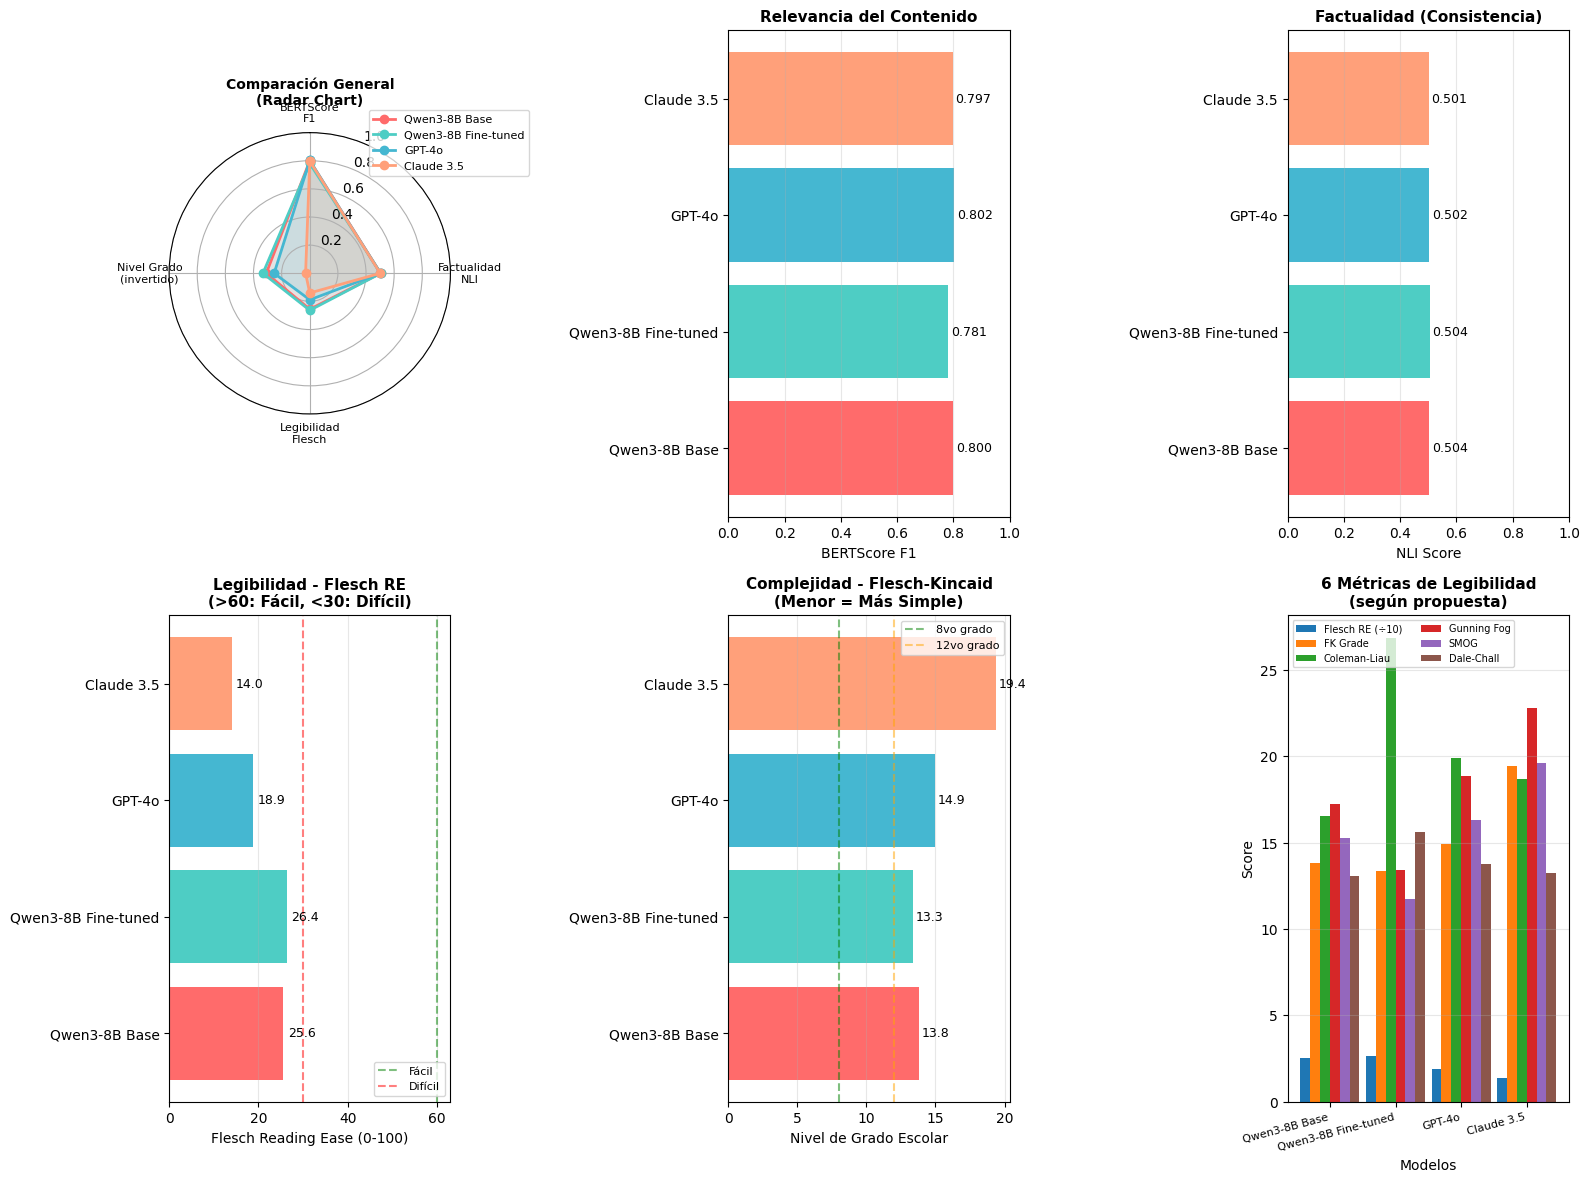

Gráfica guardada: comparison_main_metrics.png


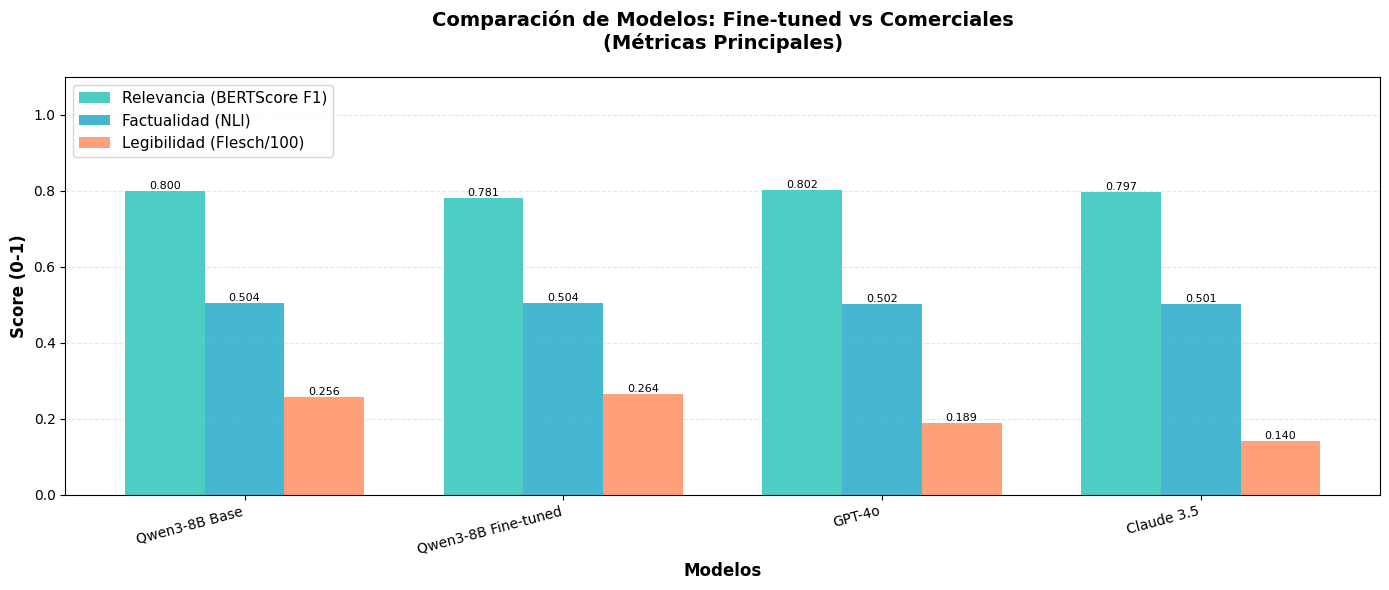


Visualizaciones completadas


In [ ]:
# ========================================
# VISUALIZACIONES COMPARATIVAS
# ========================================

import matplotlib.pyplot as plt
import seaborn as sns

if averages and len(averages) > 0:
    print("Generando visualizaciones...")

    # Preparar datos
    models = list(averages.keys())

    # 1. Gráfica de Radar con todas las métricas principales
    fig = plt.figure(figsize=(16, 12))

    # Subplot 1: Comparación general (radar chart)
    ax1 = plt.subplot(2, 3, 1, projection='polar')

    categories = ['BERTScore\nF1', 'Factualidad\nNLI', 'Legibilidad\nFlesch', 'Nivel Grado\n(invertido)']
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    ax1.set_theta_offset(np.pi / 2)
    ax1.set_theta_direction(-1)
    ax1.set_xticks(angles[:-1])
    ax1.set_xticklabels(categories, size=8)

    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

    for i, (model, avg) in enumerate(averages.items()):
        values = [
            avg['bertscore_f1'],
            avg['factual_score'],
            avg['flesch_reading_ease'] / 100,
            1 - (avg['flesch_kincaid_grade'] / 20)
        ]
        values += values[:1]
        ax1.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[i % len(colors)])
        ax1.fill(angles, values, alpha=0.15, color=colors[i % len(colors)])

    ax1.set_ylim(0, 1)
    ax1.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=8)
    ax1.set_title('Comparación General\n(Radar Chart)', size=10, fontweight='bold', pad=20)
    ax1.grid(True)

    # Subplot 2: BERTScore F1
    ax2 = plt.subplot(2, 3, 2)
    bertscore_f1 = [avg['bertscore_f1'] for avg in averages.values()]
    bars2 = ax2.barh(models, bertscore_f1, color=colors[:len(models)])
    ax2.set_xlabel('BERTScore F1', fontsize=10)
    ax2.set_title('Relevancia del Contenido', fontsize=11, fontweight='bold')
    ax2.set_xlim(0, 1)
    ax2.grid(axis='x', alpha=0.3)
    for i, v in enumerate(bertscore_f1):
        ax2.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

    # Subplot 3: Factualidad
    ax3 = plt.subplot(2, 3, 3)
    factual = [avg['factual_score'] for avg in averages.values()]
    bars3 = ax3.barh(models, factual, color=colors[:len(models)])
    ax3.set_xlabel('NLI Score', fontsize=10)
    ax3.set_title('Factualidad (Consistencia)', fontsize=11, fontweight='bold')
    ax3.set_xlim(0, 1)
    ax3.grid(axis='x', alpha=0.3)
    for i, v in enumerate(factual):
        ax3.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

    # Subplot 4: Legibilidad - Flesch Reading Ease
    ax4 = plt.subplot(2, 3, 4)
    flesch = [avg['flesch_reading_ease'] for avg in averages.values()]
    bars4 = ax4.barh(models, flesch, color=colors[:len(models)])
    ax4.set_xlabel('Flesch Reading Ease (0-100)', fontsize=10)
    ax4.set_title('Legibilidad - Flesch RE\n(>60: Fácil, <30: Difícil)', fontsize=11, fontweight='bold')
    ax4.axvline(x=60, color='green', linestyle='--', alpha=0.5, label='Fácil')
    ax4.axvline(x=30, color='red', linestyle='--', alpha=0.5, label='Difícil')
    ax4.grid(axis='x', alpha=0.3)
    for i, v in enumerate(flesch):
        ax4.text(v + 1, i, f'{v:.1f}', va='center', fontsize=9)
    ax4.legend(fontsize=8, loc='lower right')

    # Subplot 5: Nivel de Grado
    ax5 = plt.subplot(2, 3, 5)
    fk_grade = [avg['flesch_kincaid_grade'] for avg in averages.values()]
    bars5 = ax5.barh(models, fk_grade, color=colors[:len(models)])
    ax5.set_xlabel('Nivel de Grado Escolar', fontsize=10)
    ax5.set_title('Complejidad - Flesch-Kincaid\n(Menor = Más Simple)', fontsize=11, fontweight='bold')
    ax5.axvline(x=8, color='green', linestyle='--', alpha=0.5, label='8vo grado')
    ax5.axvline(x=12, color='orange', linestyle='--', alpha=0.5, label='12vo grado')
    ax5.grid(axis='x', alpha=0.3)
    for i, v in enumerate(fk_grade):
        ax5.text(v + 0.2, i, f'{v:.1f}', va='center', fontsize=9)
    ax5.legend(fontsize=8, loc='upper right')

    # Subplot 6: Comparación de todas las métricas de legibilidad
    ax6 = plt.subplot(2, 3, 6)
    x = np.arange(len(models))
    width = 0.15

    metrics = [
        ('Flesch RE (÷10)', [avg['flesch_reading_ease']/10 for avg in averages.values()]),
        ('FK Grade', [avg['flesch_kincaid_grade'] for avg in averages.values()]),
        ('Coleman-Liau', [avg['coleman_liau_index'] for avg in averages.values()]),
        ('Gunning Fog', [avg['gunning_fog'] for avg in averages.values()]),
        ('SMOG', [avg['smog_index'] for avg in averages.values()]),
        ('Dale-Chall', [avg['dale_chall_score'] for avg in averages.values()])
    ]

    for i, (label, values) in enumerate(metrics):
        ax6.bar(x + i*width - width*2.5, values, width, label=label)

    ax6.set_xlabel('Modelos', fontsize=10)
    ax6.set_ylabel('Score', fontsize=10)
    ax6.set_title('6 Métricas de Legibilidad\n(según propuesta)', fontsize=11, fontweight='bold')
    ax6.set_xticks(x)
    ax6.set_xticklabels(models, rotation=15, ha='right', fontsize=8)
    ax6.legend(fontsize=7, loc='upper left', ncol=2)
    ax6.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.savefig('comparison_all_models.png', dpi=150, bbox_inches='tight')
    print("Gráfica guardada: comparison_all_models.png")
    plt.show()

    # 2. Gráfica de barras agrupadas (métricas principales)
    fig, ax = plt.subplots(figsize=(14, 6))

    x = np.arange(len(models))
    width = 0.25

    bertscore = [avg['bertscore_f1'] for avg in averages.values()]
    factual = [avg['factual_score'] for avg in averages.values()]
    flesch_norm = [avg['flesch_reading_ease']/100 for avg in averages.values()]

    bars1 = ax.bar(x - width, bertscore, width, label='Relevancia (BERTScore F1)', color='#4ECDC4')
    bars2 = ax.bar(x, factual, width, label='Factualidad (NLI)', color='#45B7D1')
    bars3 = ax.bar(x + width, flesch_norm, width, label='Legibilidad (Flesch/100)', color='#FFA07A')

    ax.set_xlabel('Modelos', fontsize=12, fontweight='bold')
    ax.set_ylabel('Score (0-1)', fontsize=12, fontweight='bold')
    ax.set_title('Comparación de Modelos: Fine-tuned vs Comerciales\n(Métricas Principales)',
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=15, ha='right')
    ax.legend(fontsize=11, loc='upper left')
    ax.set_ylim(0, 1.1)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Añadir valores en las barras
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.savefig('comparison_main_metrics.png', dpi=150, bbox_inches='tight')
    print("Gráfica guardada: comparison_main_metrics.png")
    plt.show()

    print("\nVisualizaciones completadas")

else:
    print("No hay datos disponibles para visualizar.")
    print("Ejecuta primero las evaluaciones en la celda anterior.")


## 19.4. Comparación de Costos y Rendimiento


ANÁLISIS DE COSTOS Y RENDIMIENTO

TABLA COMPARATIVA DE COSTOS

Modelo                    Tipo                 Costo/1M tokens     
----------------------------------------------------------------------
Qwen3-8B Base             Local                $0.00               
Qwen3-8B Fine-tuned       Local                $0.00               
GPT-4o                    API Comercial        $2.50/1M input, $10.00/1M output tokens
Claude 3.5                API Comercial        $3.00/1M input, $15.00/1M output tokens

Modelo                    Setup                              
----------------------------------------------------------------------
Qwen3-8B Base             GPU (A100: $1-3/h)                 
Qwen3-8B Fine-tuned       GPU + Fine-tune (4-6h A100)        
GPT-4o                    $0.00                              
Claude 3.5                $0.00                              

RENDIMIENTO Y LATENCIA

Modelo                    Velocidad            Latencia        Escalabilidad
----

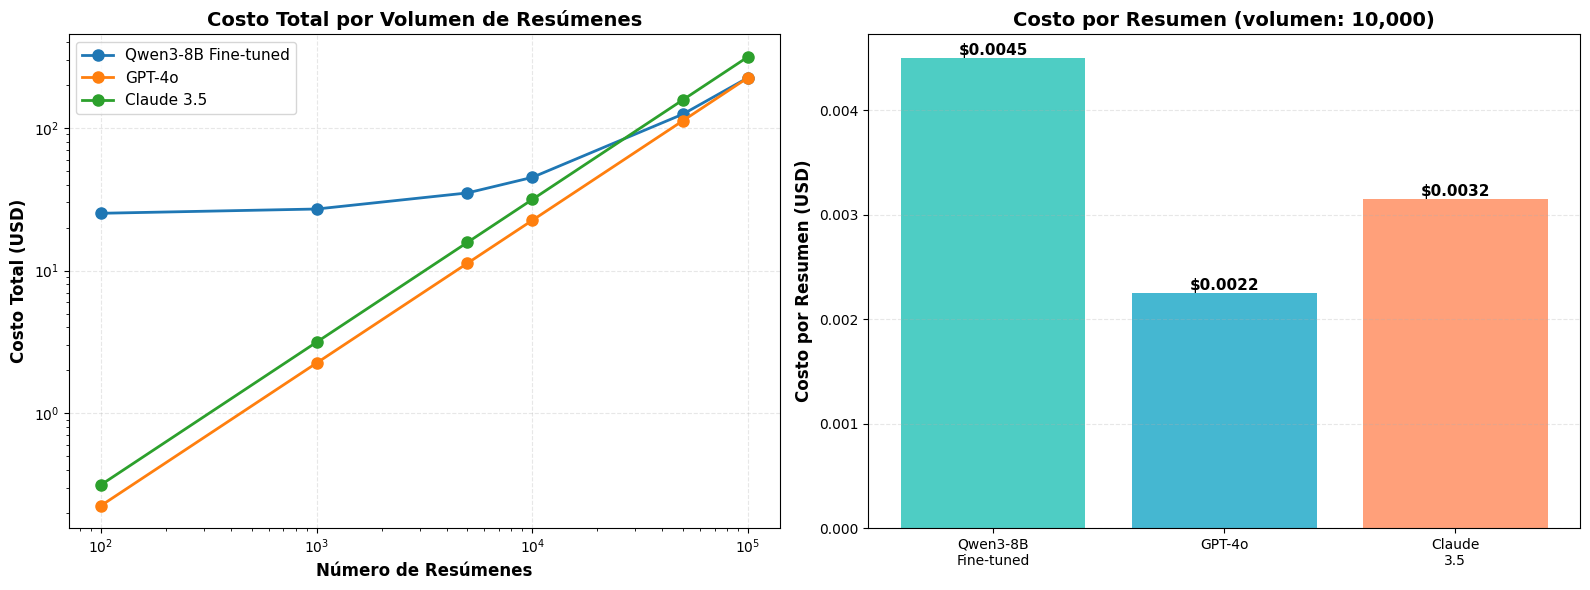


ANÁLISIS DE COSTOS COMPLETADO


In [ ]:
# ========================================
# COMPARACIÓN DE COSTOS Y RENDIMIENTO
# ========================================

print("="*70)
print("ANÁLISIS DE COSTOS Y RENDIMIENTO")
print("="*70)

# Datos de costos y rendimiento
cost_performance_data = {
    "Qwen3-8B Base": {
        "tipo": "Local",
        "parametros": "8B",
        "costo_inferencia": "$0.00",
        "costo_setup": "GPU (A100: $1-3/h)",
        "velocidad_tokens": "~50 tokens/s",
        "latencia": "~2-3s",
        "escalabilidad": "Limitada por GPU",
        "ventajas": ["Sin costo de API", "Control total", "Privacidad de datos"],
        "desventajas": ["Necesita GPU", "Mantenimiento", "Sin fine-tuning"]
    },
    "Qwen3-8B Fine-tuned": {
        "tipo": "Local",
        "parametros": "8B",
        "costo_inferencia": "$0.00",
        "costo_setup": "GPU + Fine-tune (4-6h A100)",
        "costo_finetuning": "$15-30 (una vez)",
        "velocidad_tokens": "~50 tokens/s",
        "latencia": "~2-3s",
        "escalabilidad": "Limitada por GPU",
        "ventajas": ["Especializado en dominio", "Sin costo recurrente", "Privacidad"],
        "desventajas": ["Costo inicial de fine-tuning", "Necesita GPU", "Mantenimiento"]
    },
    "GPT-4o": {
        "tipo": "API Comercial",
        "parametros": ">100B",
        "costo_inferencia": "$2.50/1M input, $10.00/1M output tokens",
        "costo_setup": "$0.00",
        "velocidad_tokens": "~40-60 tokens/s",
        "latencia": "~1-2s",
        "escalabilidad": "Ilimitada",
        "ventajas": ["Estado del arte", "Sin infraestructura", "Siempre actualizado"],
        "desventajas": ["Costo por uso", "Dependencia externa", "Privacidad limitada"]
    },
    "Claude 3.5": {
        "tipo": "API Comercial",
        "parametros": ">100B",
        "costo_inferencia": "$3.00/1M input, $15.00/1M output tokens",
        "costo_setup": "$0.00",
        "velocidad_tokens": "~50-70 tokens/s",
        "latencia": "~1-2s",
        "escalabilidad": "Ilimitada",
        "ventajas": ["Excelente calidad", "Sin infraestructura", "Buen razonamiento"],
        "desventajas": ["Más costoso", "Dependencia externa", "Privacidad limitada"]
    }
}

# Mostrar tabla comparativa
print("\n" + "="*70)
print("TABLA COMPARATIVA DE COSTOS")
print("="*70)

print(f"\n{'Modelo':<25} {'Tipo':<20} {'Costo/1M tokens':<20}")
print("-"*70)
for model, data in cost_performance_data.items():
    print(f"{model:<25} {data['tipo']:<20} {data['costo_inferencia']:<20}")

print(f"\n{'Modelo':<25} {'Setup':<35}")
print("-"*70)
for model, data in cost_performance_data.items():
    print(f"{model:<25} {data['costo_setup']:<35}")

print("\n" + "="*70)
print("RENDIMIENTO Y LATENCIA")
print("="*70)

print(f"\n{'Modelo':<25} {'Velocidad':<20} {'Latencia':<15} {'Escalabilidad'}")
print("-"*70)
for model, data in cost_performance_data.items():
    print(f"{model:<25} {data['velocidad_tokens']:<20} {data['latencia']:<15} {data['escalabilidad']}")

# Cálculo de costos para diferentes volúmenes
print("\n" + "="*70)
print("ESTIMACIÓN DE COSTOS POR VOLUMEN")
print("="*70)

volumes = [100, 1000, 10000, 100000]  # Número de resúmenes
avg_input_tokens = 300  # Promedio de tokens del texto técnico
avg_output_tokens = 150  # Promedio de tokens del resumen

print(f"\nAsumiendo: {avg_input_tokens} tokens input, {avg_output_tokens} tokens output por resumen")
print(f"\n{'Modelo':<25} {'100':<12} {'1,000':<12} {'10,000':<12} {'100,000':<12}")
print("-"*75)

for model, data in cost_performance_data.items():
    costs = []
    for vol in volumes:
        if "Local" in data['tipo']:
            # Modelos locales: costo fijo de GPU
            if model == "Qwen3-8B Base":
                # Asumiendo 1h de GPU por cada 1000 resúmenes
                gpu_hours = vol / 1000
                cost = gpu_hours * 2  # $2/h promedio
            else:  # Fine-tuned
                # Costo inicial + costo de GPU
                gpu_hours = vol / 1000
                cost = 25 + (gpu_hours * 2)  # $25 fine-tune + GPU
            costs.append(f"${cost:.2f}")
        else:
            # APIs comerciales
            total_input = vol * avg_input_tokens
            total_output = vol * avg_output_tokens

            if model == "GPT-4o":
                cost = (total_input / 1_000_000) * 2.50 + (total_output / 1_000_000) * 10.00
            else:  # Claude
                cost = (total_input / 1_000_000) * 3.00 + (total_output / 1_000_000) * 15.00

            costs.append(f"${cost:.2f}")

    print(f"{model:<25} {costs[0]:<12} {costs[1]:<12} {costs[2]:<12} {costs[3]:<12}")

# Recomendaciones
print("\n" + "="*70)
print("RECOMENDACIONES POR ESCENARIO")
print("="*70)

scenarios = {
    "Proyecto de Investigación": {
        "volumen": "< 1,000 resúmenes",
        "recomendacion": "GPT-4o o Claude 3.5",
        "razon": "Mejor calidad, sin infraestructura, bajo volumen hace el costo aceptable"
    },
    "Prototipo/MVP": {
        "volumen": "1,000 - 10,000 resúmenes",
        "recomendacion": "Qwen3-8B Fine-tuned",
        "razon": "Balance entre calidad y costo, control total del modelo"
    },
    "Producción (bajo volumen)": {
        "volumen": "< 5,000/mes",
        "recomendacion": "APIs Comerciales",
        "razon": "Sin mantenimiento, siempre actualizado, costo manejable"
    },
    "Producción (alto volumen)": {
        "volumen": "> 10,000/mes",
        "recomendacion": "Qwen3-8B Fine-tuned",
        "razon": "Costo fijo más económico a escala, control total"
    },
    "Datos Sensibles": {
        "volumen": "Cualquiera",
        "recomendacion": "Qwen3-8B Fine-tuned (Local)",
        "razon": "Privacidad garantizada, sin envío de datos a terceros"
    },
    "Investigación Académica": {
        "volumen": "Variable",
        "recomendacion": "Comparar ambos enfoques",
        "razon": "Validar que fine-tuning mejora sobre modelos comerciales"
    }
}

for scenario, info in scenarios.items():
    print(f"\n{scenario}:")
    print(f"  Volumen: {info['volumen']}")
    print(f"  Recomendación: {info['recomendacion']}")
    print(f"  Razón: {info['razon']}")

# Visualización de costos
print("\n" + "="*70)
print("Generando visualización de costos...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfica 1: Costo por volumen
volumes_plot = [100, 1000, 5000, 10000, 50000, 100000]

for model in ["Qwen3-8B Fine-tuned", "GPT-4o", "Claude 3.5"]:
    costs_plot = []
    data = cost_performance_data[model]

    for vol in volumes_plot:
        if "Local" in data['tipo']:
            gpu_hours = vol / 1000
            cost = 25 + (gpu_hours * 2)  # Fine-tune cost + GPU
        else:
            total_input = vol * avg_input_tokens
            total_output = vol * avg_output_tokens
            if model == "GPT-4o":
                cost = (total_input / 1_000_000) * 2.50 + (total_output / 1_000_000) * 10.00
            else:
                cost = (total_input / 1_000_000) * 3.00 + (total_output / 1_000_000) * 15.00

        costs_plot.append(cost)

    ax1.plot(volumes_plot, costs_plot, marker='o', linewidth=2, label=model, markersize=8)

ax1.set_xlabel('Número de Resúmenes', fontsize=12, fontweight='bold')
ax1.set_ylabel('Costo Total (USD)', fontsize=12, fontweight='bold')
ax1.set_title('Costo Total por Volumen de Resúmenes', fontsize=14, fontweight='bold')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, linestyle='--')

# Gráfica 2: Costo por resumen
costs_per_summary = []
models_plot = []

for model in ["Qwen3-8B Fine-tuned", "GPT-4o", "Claude 3.5"]:
    data = cost_performance_data[model]
    models_plot.append(model.replace(" ", "\n"))

    # Calcular costo por resumen para 10,000 resúmenes
    vol = 10000
    if "Local" in data['tipo']:
        gpu_hours = vol / 1000
        total_cost = 25 + (gpu_hours * 2)
    else:
        total_input = vol * avg_input_tokens
        total_output = vol * avg_output_tokens
        if model == "GPT-4o":
            total_cost = (total_input / 1_000_000) * 2.50 + (total_output / 1_000_000) * 10.00
        else:
            total_cost = (total_input / 1_000_000) * 3.00 + (total_output / 1_000_000) * 15.00

    cost_per = total_cost / vol
    costs_per_summary.append(cost_per)

bars = ax2.bar(models_plot, costs_per_summary, color=['#4ECDC4', '#45B7D1', '#FFA07A'])
ax2.set_ylabel('Costo por Resumen (USD)', fontsize=12, fontweight='bold')
ax2.set_title('Costo por Resumen (volumen: 10,000)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Añadir valores en las barras
for bar, cost in zip(bars, costs_per_summary):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'${cost:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('cost_comparison.png', dpi=150, bbox_inches='tight')
print("Gráfica guardada: cost_comparison.png")
plt.show()

print("\n" + "="*70)
print("ANÁLISIS DE COSTOS COMPLETADO")
print("="*70)


## 19.5. Instrucciones Detalladas para API Keys


In [ ]:
# ========================================
# INSTRUCCIONES PARA API KEYS
# ========================================

print("="*70)
print("CÓMO CONFIGURAR API KEYS PARA MODELOS COMERCIALES")
print("="*70)

print("""
Para habilitar las comparaciones con GPT-4o y Claude 3.5, necesitas:

1. OBTENER API KEYS:

   OpenAI (GPT-4o):
   - Crear cuenta en: https://platform.openai.com/
   - Ir a: API Keys > Create new secret key
   - Copiar la clave (empieza con 'sk-...')

   Anthropic (Claude 3.5):
   - Crear cuenta en: https://console.anthropic.com/
   - Ir a: API Keys > Create Key
   - Copiar la clave (empieza con 'sk-ant-...')

2. CONFIGURAR EN COLAB:

   Opción A - Variables de entorno (Recomendado):
   ```python
   import os
   os.environ['OPENAI_API_KEY'] = 'tu-clave-aqui'
   os.environ['ANTHROPIC_API_KEY'] = 'tu-clave-aqui'
   ```

   Opción B - Usar Colab Secrets (Más seguro):
   - En Colab: Menú izquierdo > 🔑 Secrets
   - Agregar: OPENAI_API_KEY y ANTHROPIC_API_KEY
   - Habilitar acceso al notebook

   Luego en el código:
   ```python
   from google.colab import userdata
   os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
   os.environ['ANTHROPIC_API_KEY'] = userdata.get('ANTHROPIC_API_KEY')
   ```

3. COSTOS APROXIMADOS:

   GPT-4o: $2.50 input + $10.00 output por 1M tokens
   - ~100 resúmenes: $0.04 - $0.10
   - ~1,000 resúmenes: $0.40 - $1.00
   - ~10,000 resúmenes: $4.00 - $10.00

   Claude 3.5: $3.00 input + $15.00 output por 1M tokens
   - ~100 resúmenes: $0.05 - $0.12
   - ~1,000 resúmenes: $0.50 - $1.20
   - ~10,000 resúmenes: $5.00 - $12.00

4. VERIFICAR CONFIGURACIÓN:

   Ejecuta esta celda después de configurar:
""")

# Código de verificación
print("\n" + "="*70)
print("VERIFICACIÓN DE API KEYS")
print("="*70)

import os

openai_key = os.getenv("OPENAI_API_KEY", "")
anthropic_key = os.getenv("ANTHROPIC_API_KEY", "")

if openai_key:
    print(f"\n✓ OpenAI API Key configurada (termina en: ...{openai_key[-4:]})")
else:
    print("\n✗ OpenAI API Key NO configurada")
    print("  Configura con: os.environ['OPENAI_API_KEY'] = 'tu-clave'")

if anthropic_key:
    print(f"✓ Anthropic API Key configurada (termina en: ...{anthropic_key[-4:]})")
else:
    print("✗ Anthropic API Key NO configurada")
    print("  Configura con: os.environ['ANTHROPIC_API_KEY'] = 'tu-clave'")

if openai_key or anthropic_key:
    print("\n" + "="*70)
    print("Configuración exitosa. Puedes ejecutar la celda 40 para comparar.")
    print("="*70)
else:
    print("\n" + "="*70)
    print("SIN API KEYS: Solo se compararán los modelos locales.")
    print("="*70)



CÓMO CONFIGURAR API KEYS PARA MODELOS COMERCIALES

Para habilitar las comparaciones con GPT-4o y Claude 3.5, necesitas:

1. OBTENER API KEYS:
   
   OpenAI (GPT-4o):
   - Crear cuenta en: https://platform.openai.com/
   - Ir a: API Keys > Create new secret key
   - Copiar la clave (empieza con 'sk-...')
   
   Anthropic (Claude 3.5):
   - Crear cuenta en: https://console.anthropic.com/
   - Ir a: API Keys > Create Key
   - Copiar la clave (empieza con 'sk-ant-...')

2. CONFIGURAR EN COLAB:
   
   Opción A - Variables de entorno (Recomendado):
   ```python
   import os
   os.environ['OPENAI_API_KEY'] = 'tu-clave-aqui'
   os.environ['ANTHROPIC_API_KEY'] = 'tu-clave-aqui'
   ```
   
   Opción B - Usar Colab Secrets (Más seguro):
   - En Colab: Menú izquierdo > 🔑 Secrets
   - Agregar: OPENAI_API_KEY y ANTHROPIC_API_KEY
   - Habilitar acceso al notebook
   
   Luego en el código:
   ```python
   from google.colab import userdata
   os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY

## 20. Visualización de Resultados

In [ ]:
# Visualización de resultados
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_results(results_dict):
    if not results_dict:
        print("No hay resultados para visualizar")
        return

    # Preparar datos
    models = list(results_dict.keys())
    bertscore = [r['relevance']['f1'] for r in results_dict.values()]
    factual = [r['factual']['score'] for r in results_dict.values()]
    readability = [r['readability']['flesch_reading_ease']/100 for r in results_dict.values()]

    # Crear gráficas
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Gráfica 1: BERTScore
    axes[0].bar(models, bertscore, color='skyblue')
    axes[0].set_title('Relevancia (BERTScore F1)')
    axes[0].set_ylabel('Score')
    axes[0].set_ylim([0, 1])
    axes[0].tick_params(axis='x', rotation=45)

    # Gráfica 2: Factualidad
    axes[1].bar(models, factual, color='lightgreen')
    axes[1].set_title('Factualidad (NLI)')
    axes[1].set_ylabel('Score')
    axes[1].set_ylim([0, 1])
    axes[1].tick_params(axis='x', rotation=45)

    # Gráfica 3: Legibilidad
    axes[2].bar(models, readability, color='salmon')
    axes[2].set_title('Legibilidad (Flesch normalizado)')
    axes[2].set_ylabel('Score')
    axes[2].set_ylim([0, 1])
    axes[2].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Gráfica combinada
    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(models))
    width = 0.25

    ax.bar(x - width, bertscore, width, label='Relevancia', color='skyblue')
    ax.bar(x, factual, width, label='Factualidad', color='lightgreen')
    ax.bar(x + width, readability, width, label='Legibilidad', color='salmon')

    ax.set_xlabel('Modelos')
    ax.set_ylabel('Score')
    ax.set_title('Comparación de Modelos por Métrica')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim([0, 1.1])
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

print("Función de visualización lista")
print("\nPara usar:")
print("  visualize_results(results_comparison)")

Función de visualización lista

Para usar:
  visualize_results(results_comparison)


## 21. Exportar Resultados

In [ ]:
# Exportar resultados para análisis
def export_results(results_dict, filename="results_comparison"):
    """
    Exporta resultados a CSV para análisis
    """
    if not results_dict:
        print("No hay resultados para exportar")
        return

    export_data = []

    for model_name, metrics in results_dict.items():
        export_data.append({
            'Model': model_name,
            'BERTScore_Precision': metrics['relevance']['precision'],
            'BERTScore_Recall': metrics['relevance']['recall'],
            'BERTScore_F1': metrics['relevance']['f1'],
            'Factual_Score': metrics['factual']['score'],
            'Flesch_Reading_Ease': metrics['readability']['flesch_reading_ease'],
            'Flesch_Kincaid_Grade': metrics['readability']['flesch_kincaid_grade']
        })

    df_results = pd.DataFrame(export_data)
    df_results.to_csv(filename, index=False)

    print(f"Resultados exportados a: {filename}")
    print("\nResumen:")
    print(df_results.to_string(index=False))

    return df_results

print("Función de exportación lista")
print("\nPara usar:")
print("  df_results = export_results(results_comparison)")

Función de exportación lista

Para usar:
  df_results = export_results(results_comparison)
